###Importation

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from pandas.api.types import CategoricalDtype
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
!pip install implicit

In [ ]:
pip install sweetviz

In [ ]:
pip install lightfm

- Reference : https://towardsdatascience.com/plotting-in-pandas-just-got-prettier-289d0e0fe5c0

In [ ]:
pip install pandas-bokeh

In [ ]:
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install @bokeh/jupyter_bokeh

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

#Part 1: Alternating Least Square

In [ ]:
                          #loading data
website_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(website_url) 

In [ ]:
#df.to_csv('Retail_df.csv')

In [ ]:
#df = pd.read_csv('/content/Retail_df.csv')

###Expository Data Analysis

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- Attribute Information:

  - **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

  - **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

  - **Description**: Product (item) name. Nominal.

  - **Quantity**: The quantities of each product (item) per transaction. Numeric.

  - **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

 - **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

  - **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

  - **Country**: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
print("The dimension of the data is " + str(df.shape))

The dimension of the data is (541909, 8)


In [ ]:
                                                    #Dataset Information Table for each colum
Data_Dict=pd.DataFrame(df.dtypes)                   #datatype of each column
Data_Dict['Missing Val'] = df.isnull().sum()        #num of missing values, add to table
Data_Dict['Num of Zeros'] = (df == 0).sum(0)
Data_Dict['% Num of Zeros'] = round((Data_Dict['Num of Zeros'].astype(int)/df.shape[0] * 100),2)
Data_Dict['nUnique Values']=df.nunique()            #num of unique entries, add to table
Data_Dict=Data_Dict.rename(columns={0:'Datatype'})
print('The Table below shows the Data Information of each column ')
Data_Dict

The Table below shows the Data Information of each column 


,Datatype,Missing Val,Num of Zeros,% Num of Zeros,nUnique Values
InvoiceNo,object,0,0,0.00,25900
StockCode,object,0,0,0.00,4070
Description,object,1454,0,0.00,4223
Quantity,int64,0,0,0.00,722
InvoiceDate,datetime64[ns],0,0,0.00,23260
UnitPrice,float64,0,2515,0.46,1630
CustomerID,float64,135080,0,0.00,4372
Country,object,0,0,0.00,38


In [ ]:
                          #removing data without customerID
                          #using the pd.isnull to test for rows 
                          #with missing data and only keep the rows that have a customer ID.
df_new = df.loc[pd.isnull(df.CustomerID) == False]
df_new.shape

(406829, 8)

In [ ]:
print("Number of distinct customers:", df_new["CustomerID"].nunique())       #Num of distinct customer
print("Number of distinct Items:", df_new["Description"].nunique())          #Num of distinct items
print("Number of distinct StockCode:", df_new["StockCode"].nunique())        #Num of distinct items

Number of distinct customers: 4372
Number of distinct Items: 3896
Number of distinct StockCode: 3684


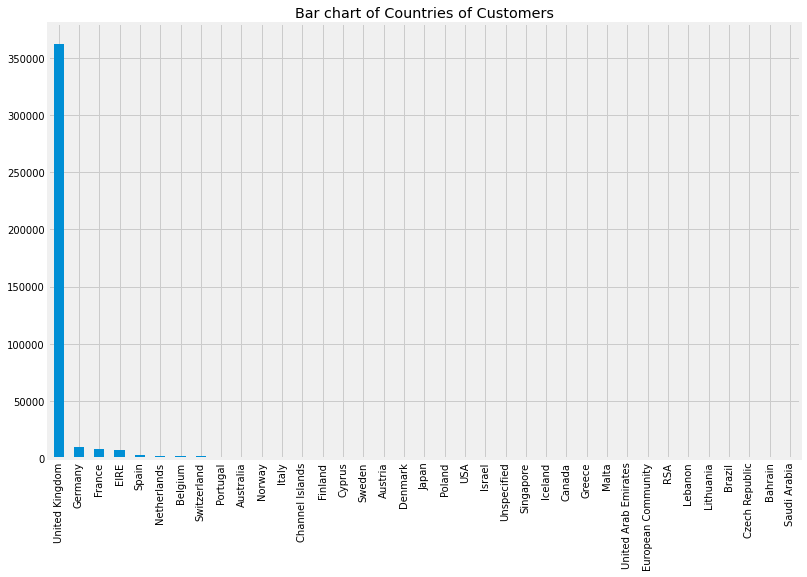

In [ ]:
                        ##Customers by country
plt.figure(figsize=(12,8))
df_new.Country.value_counts().plot.bar()     #use plot.barh() to get horizonta=al bar charts...
plt.title("Bar chart of Countries of Customers")
plt.grid(True)
#df_new.groupby(["Country"]).agg({'CustomerID':'value_counts'})                    

In [ ]:
df_new[df_new['UnitPrice'] > 1000].count()
#df_new['UnitPrice'].describe()

InvoiceNo      46
StockCode      46
Description    46
Quantity       46
InvoiceDate    46
UnitPrice      46
CustomerID     46
Country        46
dtype: int64

In [ ]:
df_new['UnitPrice'].describe()

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [ ]:
# def price_converter(df,cut_points,column_name,new_catergories):
#     df['clientAge']=LoanDFF['clientAge'].fillna(-0.5)                              #Handling missing values
#     LoanDFF['Age_Catergories']=pd.cut(LoanDFF['clientAge'],cut_points,labels=label_names)
#     return LoanDFF

def frange(start, stop, step=1.0):    #getting list in float
    i = start
    while i < stop:
        yield i
        i += step

# get_list_20 = list(frange(0.5,20,0.5))  
# get_list_100 = list(frange(20,100,1))  
# get_list_500 = list(frange(100,500,20))  
# get_list_max = list(frange(500,,20)) 
# print(get_list)        

In [ ]:
def price_converter(df,cut_points,column_name,new_catergories,cat_label):
     df[column_name] = df[column_name].fillna(df[column_name].mean())                              #Handling missing values
     df[new_catergories]=pd.cut(df[column_name],cut_points,labels=cat_label)
     return df

cut_points=[0,2,5,10,15,20,30,50,100,200,500,1000,38970]
price_catergories=['0-2Pounds','2-5Pounds','5-10Pounds','10-15Pounds',
             '15-20Pounds','20-30Pounds','30-50Pounds','50-100Pounds',
             '100-200Pounds','200-500Pounds','500-1000Pounds','Above 1000Pounds']      #New Age catergories

In [ ]:
get_df= price_converter(df_new,cut_points,'UnitPrice','price_catergories',price_catergories)   #Convert Age in the train data to catergorical
get_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_catergories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2-5Pounds
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2-5Pounds
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2-5Pounds
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2-5Pounds
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2-5Pounds


In [ ]:
#get_df['price_catergories'].value_counts()
#price catergories in catergoriees
print(get_df['price_catergories'].value_counts(normalize= True)*100)

0-2Pounds           52.671532
2-5Pounds           34.214544
5-10Pounds          10.226924
10-15Pounds          1.936139
15-20Pounds          0.617765
30-50Pounds          0.136680
20-30Pounds          0.101035
100-200Pounds        0.036874
50-100Pounds         0.021141
200-500Pounds        0.016225
Above 1000Pounds     0.011308
500-1000Pounds       0.009833
Name: price_catergories, dtype: float64


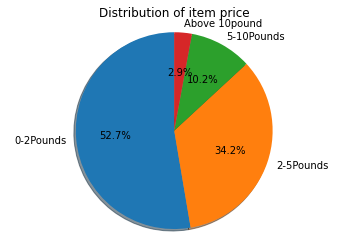

In [ ]:
#get_df['price_catergories'].value_counts().plot.barh()
sizes_=[52.67,34.21,10.23,2.89]
plt.pie(sizes_,
        labels=['0-2Pounds','2-5Pounds','5-10Pounds','Above 10pound',],
        startangle=90,
        shadow=True,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of item price')
plt.show()

In [ ]:
                                                 #creating a lookup table to track of each item and its description  
                                                  #its a simple pandas dataframe of the unique product ID/product 
                                                  #descriptions available....
item_lookup = df_new[['StockCode', 'Description']].drop_duplicates()   #Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)                      #Encode as strings for future lookup ease
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [ ]:
                                                    ##con
df_new["CustomerID"]   = df_new.CustomerID.astype(int)
used_dff = df_new[['CustomerID','StockCode','Quantity']]
used_df = used_dff.groupby(['CustomerID','StockCode']).sum().reset_index()  ##groupby CustomerID && Item, then summing quantity values

                                  #replacing a sum of 0 with a sum of 1
                                  #sum of 0 means user returns item..
used_df.Quantity.loc[used_df.Quantity==0] = 1
                                 #get only customers with positive num of quantities
user_item_info = used_df.query('Quantity > 0')  
print(user_item_info.shape)
user_item_info.head()

(266723, 3)


,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [ ]:
#df_new["CustomerID"]   = df_new.CustomerID.astype(int)
descr = df_new[['CustomerID','Description','Quantity']]

                                  ##groupby CustomerID && Item, then summing quantity values
descr_df = descr.groupby(['CustomerID','Description']).sum().reset_index()  

                                  #replacing a sum of 0 with a sum of 1
                                  #sum of 0 means user returns item..
descr_df.Quantity.loc[descr_df.Quantity==0] = 1
                                 #get only customers with positive num of quantities
user_item_desr = descr_df.query('Quantity > 0')  
print(user_item_desr.shape)
user_item_desr.head()

(268211, 3)


,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


###Creating a Rating Matrix:
- now without explicit rating, the purchase quantity can serve as an implicit feedback for us.

- It represent a “confidence” in terms of how strong the user-item was. 

- Items with a larger number of purchases by a customer can carry more weight in the ratings matrix of purchases.

In [ ]:
                                                                ##creating the sparse rating matrix
CUSTOMERS = list(np.sort(user_item_info.CustomerID.unique()))   #Get list of unique customers..
STOCKCODE = list(user_item_info.StockCode.unique())             #Get list of unique items
QUANTITY =  list(user_item_info.Quantity)                       #get all quantities

print("Num of unique customers: ",len(CUSTOMERS))
print("Num of unique Items: ",len(STOCKCODE))
print("Num of Item quantities: ",len(QUANTITY))

Num of unique customers:  4338
Num of unique Items:  3664
Num of Item quantities:  266723


In [ ]:
len(item_lookup.Description.unique())

3896

In [ ]:
# df = pd.DataFrame({'A':[1,2,3,4,5], 'B':['a','b','c','d','e'], 'C':['A','B','A','B','A']})
# df['C']=df['C'].astype(CategoricalDtype(categories=['A','B']))
# df

In [ ]:
user_item_info.head()

,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [ ]:
#rows = user_item_info.CustomerID.astype('category', categories = CUSTOMERS).cat.codes 
rows = user_item_info.CustomerID.astype(CategoricalDtype(categories=CUSTOMERS)).cat.codes
rows

0            0
1            1
2            1
3            1
4            1
          ... 
267610    4337
267611    4337
267612    4337
267613    4337
267614    4337
Length: 266723, dtype: int16

In [ ]:
cols = user_item_info.StockCode.astype(CategoricalDtype(categories=STOCKCODE)).cat.codes
cols

0            0
1            1
2            2
3            3
4            4
          ... 
267610    2012
267611    3093
267612    2147
267613    2880
267614     309
Length: 266723, dtype: int16

In [ ]:
Rating_matrix = sparse.csr_matrix((QUANTITY, (rows,cols)),
                                     shape=(len(CUSTOMERS),len(STOCKCODE)))
Rating_matrix

<4338x3664 sparse matrix of type '<class 'numpy.longlong'>'
	with 266723 stored elements in Compressed Sparse Row format>

In [ ]:
                    ##Checking sparsity of the rating matrix:
Matrix_size = Rating_matrix.shape[0]*Rating_matrix.shape[1]
Num_of_purchase = len(Rating_matrix.nonzero()[0])
sparsity = 100*(1-(Num_of_purchase/Matrix_size))
print("Shape  of the rating matrix: ", Rating_matrix.shape)
print("Num of purchase: ",Matrix_size)
print("Num of purchase: ",Num_of_purchase)
print("Percentage Sparsity: ", sparsity)

Shape  of the rating matrix:  (4338, 3664)
Num of purchase:  15894432
Num of purchase:  266723
Percentage Sparsity:  98.32190920694744


- 4338 uniques  VS 3664 unique items, with  266723 different purchase

- Sparsity should be below 99.5% for collaborative filtering to work


###Training and Testing set:

- The method of getting training and testing set is as follows;

- Test set is an exact copy of our original data.

- The training set, however, will mask a random percentage of user/item interactions and act as if the user never purchased the item (making it a sparse entry with a zero)

- Then during testing, we check in the test set which items were recommended to the user that they ended up actually purchasing.

- If the users frequently ended up purchasing the items most recommended to them by the system, we can conclude the system seems to be working.

In [ ]:
                                                ##takes rating matrix and masks a certain % 
                                                ##of the user-item interaction
def make_TrainTest(ratings_matrix,pct_mask=0.2):
  test_set = ratings_matrix.copy()              #making a copy of the rating matrix as text_set
  test_set[test_set!=0]=1                       #storing this as a binary preference matrix 

  train_set = ratings_matrix.copy() 
  nonzero_inds = train_set.nonzero()            #get indices where interaction actually exist
  nonzero_pairs = list(zip(nonzero_inds[0],     #user-item indices into list
                          nonzero_inds[1]))   
  random.seed(0) 
  num_samples = int(np.ceil(pct_mask*len(nonzero_pairs)))  #num of samples to mask
  samples = random.sample(nonzero_pairs, num_samples) 


  user_inds = [i[0] for i in samples]             #Get the user row indices
  item_inds = [i[1] for i in samples] # Get the item column indices
  train_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
  train_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
  return train_set, test_set, list(set(user_inds)) # Output the unique list of use

- The function above will return 3 things;

- Train set- {with some samples delibrately masked out},

- Test set - {that has been binarized to 0/1 for purchased/not purchased}

-  and a list of which users had at least one item masked. 

- the performance of the recommender system will be tested on these users only. 

In [ ]:
train_set ,test_set,masked_users = make_TrainTest(Rating_matrix, pct_mask=0.2)

In [ ]:
len(masked_users)

4042

###Implementation of Alternating Least Square [ALS]:  


[Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)

[Benfred Implicit](https://github.com/benfred/implicit)

- Convert the sparse rating matrix into a confidence matrix:   
 $$C_{ui} = 1 + \alpha r_{ui} $$

 - $C_{ui}$ = confidence matrix of users $u$ andf items $i$

 -  $\alpha$ = a linear scaling of the rating preferences (i.e num of purchases)

 -  $r_{ui}$ = original matrix of purchases

- The two main equations we will be iterating  between are;
  
$$x_{u} = \left(Y^{T}Y +  Y^{T} (C^{u}-I)Y + \lambda I\right)^{-1} Y^{T}C^{u}p(u)$$

$$y_{i} = \left(X^{T}X +  X^{T} (C^{i}-I)X + \lambda I\right)^{-1} X^{T}C^{i}p(i)$$

In [ ]:
import implicit
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=32, 
                                                          regularization = 0.1, 
                                                         iterations = 100,
                                                          use_gpu = False  #use True if connected to GPU
                                                          )
  
  
 ##returns ==  user_vecs: Array of latent factors for each USERS in the training set (M X K)
              #item_vecs: Array of latent factors for each ITEMS in the training set (K X N)  
              #where K == num of latent factors      



##reducing number of latent factors can improve the AUC    

In [ ]:
print("Shape of User features: ", user_vecs.shape)
print("Shape of Item features: ", item_vecs.shape)

Shape of User features:  (4338, 32)
Shape of Item features:  (3664, 32)


###Evaluating the recommender system

- The training set has 20% data masked,and this will be used for the evaluation

- The evaluation will be to see **if the order of recommendations given for each user matches the items they ended up purchasing.**

- **Method 1**: using ROC curve; a greater area under the curve{AUC} means we are recommending items that end up being purchased near the top of the list of recommended items.



In [ ]:
def auc_score(predictions,test):
  fpr,tpr,threshold = metrics.roc_curve(test, predictions)
  auc_score = metrics.auc(fpr, tpr)
  return auc_score


def mean_auc(train_set,test_set,latent_features,masked_users) :
  user_AUC = []
  popularity_AUC = []                     
                                                       #sum of item interactions to find most popular items
  popular_item = np.array(test_set.sum(axis = 0)).reshape(-1)
  item_vectors = latent_features[1]                     #item latent features: matrix_V
  for user in masked_users:
    train_row  = train_set[user,:].toarray().reshape(-1)  ##for each user in the training set
    zero_index = np.where(train_row==0)                   ##get the index where interaction has not yet occurred 

                                                          #extract the user latent features... 
    user_vector = latent_features[0][user,:]              #get me each row in the predicted rating matrix--> 
                                                          #user latent features: matrix_U

    pred_rating = user_vector.dot(item_vectors).toarray()[0,zero_index].reshape(-1)  #user predicted ratings based on 

    actual_rating = test_set[user,:].toarray()[0,zero_index].reshape(-1) 
    pop = popular_item[zero_index]                      #item popularity of our chosen item: 
                                                        #to test with our system recommending popular item for every user
    user_AUC.append(auc_score(pred_rating, actual_rating))
    popularity_AUC.append(auc_score(pop,actual_rating))
    AVG_test_AUC = float('%.3f'%np.mean(user_AUC))
    AVG_pop_AUC = float('%.3f'%np.mean(popularity_AUC))

  return AVG_test_AUC,AVG_pop_AUC

In [ ]:
                      ##converting the ALS output to csr_matrix , and transposing th eitem vectors:
user_vecs_csr = sparse.csr_matrix(user_vecs) 
item_vecs_csr = sparse.csr_matrix(item_vecs.T) 

latent_features = [user_vecs_csr,item_vecs_csr]
AVG_test_AUC,AVG_pop_AUC  = mean_auc(train_set,test_set,
                                  latent_features,masked_users)

print("Mean Test AUC:",AVG_test_AUC)        ##AUC based on recommendation on users' interactions
print("Mean Popularity AUC:",AVG_pop_AUC)   ##Auc based on system recommending just the most popular items

Mean Test AUC: 0.87
Mean Popularity AUC: 0.814


- A high AUC means the system is recommending items the user had purchased in the test set far more frequently than items the user never ended up purchasing.

###Example

In [ ]:
customers_arr = np.array(CUSTOMERS)     #Array of unique customer IDs from the ratings matrix
items_arr =  np.array(STOCKCODE)        #Array of unique product IDs from the ratings matrix

                                        #get the items that have already been purchased by
                                        #...a specific customer in the training set
def get_item_already_bought(customer_id,train_set,customers_list,items_list,item_lookup):
                                      
  customers_index = np.where(customers_list == customer_id)[0][0]    #get the row index  of the customer_ID 
  customer_item_index = train_set[customers_index,:].nonzero()[1]    #get column indices of purchased items by the customer 
  Item_stockcode = items_list[customer_item_index] 
  get_item = item_lookup.loc[item_lookup.StockCode.isin(Item_stockcode)]
                                                              #return :A list of item IDs and item descriptions 
  return get_item                                             #..for a particular customer that were already purchased in the training set     

In [ ]:
customers_arr[:3]   #check out first 3customers

array([12346, 12347, 12348])

In [ ]:
customers_index = np.where(customers_arr == 12346)[0][0] 
customers_index

0

In [ ]:
                ##get item already bought by a user...
already_purchased_ =get_item_already_bought(12346,train_set,customers_arr,items_arr,item_lookup)
already_purchased_

,StockCode,Description
61619,23166,MEDIUM CERAMIC TOP STORAGE JAR


- This customer already purchased {MEDIUM CERAMIC TOP STORAGE JAR}

- Now lets find what the system recommends..

In [ ]:
                             #function to recommend top items for all users... 
def get_recommended_items(customer_id,train_set,user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
  customers_index = np.where(customer_list == customer_id)[0][0] 
  customer_rating = train_set[customers_index,:].toarray()          #get customer rating from the rating_matrix(train_set)
  customer_rating = customer_rating.reshape(-1) + 1                 #adding 1 to every values; items not purchased yet(0 before), will not become 1
  customer_rating[customer_rating > 1] = 0                          #make all items already purchased  to be 0
  recommend_vec = user_vecs[customers_index,:].dot(item_vecs.T)     #Get dot product of user vector and all item vectors
                                                                    #making the recommendation vector between 0 and 1
  min_max = MinMaxScaler()
  rec_vector_scaled = min_max.fit_transform(recommend_vec.reshape(-1,1))[:,0] 

  recommend_vector = customer_rating*rec_vector_scaled              #item already purchased have their recommendation multiplied by 0
  item_index = np.argsort(recommend_vector)[::-1][:num_items]       #Sorting the indices of the recommended_items into order 
  recommend_list = []
  for i in item_index:
    code = item_list[i]                                            #appening item description to list
    recommend_list.append([code,item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
  codes = [item[0] for item in recommend_list]
  descriptions = [item[1] for item in recommend_list]
  final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions})   #Create a dataframe 
  recommended = final_frame[['StockCode', 'Description']]                         #Switch order of columns around
  return recommended

- The function above retrieves the N highest ranking dot products between the user and item vectors for a particular user.

-  Items already purchased are not recommended to the user.

In [ ]:
recommended_ = get_recommended_items(12346, train_set,user_vecs, item_vecs, 
                      customers_arr,items_arr, item_lookup,num_items = 10)


recommended_

,StockCode,Description
0,23165,LARGE CERAMIC TOP STORAGE JAR
1,23167,SMALL CERAMIC TOP STORAGE JAR
2,23168,CLASSIC SUGAR DISPENSER
3,22962,JAM JAR WITH PINK LID
4,22963,JAM JAR WITH GREEN LID
5,16014,SMALL CHINESE STYLE SCISSOR
6,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE
7,22989,SET 2 PANTRY DESIGN TEA TOWELS
8,23293,SET OF 12 FAIRY CAKE BAKING CASES
9,23295,SET OF 12 MINI LOAF BAKING CASES


In [ ]:
recommended_["Description"]

0         LARGE CERAMIC TOP STORAGE JAR
1        SMALL CERAMIC TOP STORAGE JAR 
2               CLASSIC SUGAR DISPENSER
3                 JAM JAR WITH PINK LID
4                JAM JAR WITH GREEN LID
5           SMALL CHINESE STYLE SCISSOR
6    SET 6 SCHOOL MILK BOTTLES IN CRATE
7        SET 2 PANTRY DESIGN TEA TOWELS
8     SET OF 12 FAIRY CAKE BAKING CASES
9      SET OF 12 MINI LOAF BAKING CASES
Name: Description, dtype: object

In [ ]:
already_purchased_["Description"].item()   ##can only be used for 1 -array

'MEDIUM CERAMIC TOP STORAGE JAR'

In [ ]:
pd.DataFrame({'Purchased_Item': [already_purchased_["Description"].item(),'-','-','-','-','-','-','-','-','-'],
              'Recommended_items': recommended_["Description"]}) 

,Purchased_Item,Recommended_items
0,MEDIUM CERAMIC TOP STORAGE JAR,LARGE CERAMIC TOP STORAGE JAR
1,-,SMALL CERAMIC TOP STORAGE JAR
2,-,CLASSIC SUGAR DISPENSER
3,-,JAM JAR WITH PINK LID
4,-,JAM JAR WITH GREEN LID
5,-,SMALL CHINESE STYLE SCISSOR
6,-,SET 6 SCHOOL MILK BOTTLES IN CRATE
7,-,SET 2 PANTRY DESIGN TEA TOWELS
8,-,SET OF 12 FAIRY CAKE BAKING CASES
9,-,SET OF 12 MINI LOAF BAKING CASES


In [ ]:
##testing for customer :
purchased_items = get_item_already_bought(12353,train_set,customers_arr,items_arr,item_lookup)
purchased_items

,StockCode,Description
2148,37446,MINI CAKE STAND WITH HANGING CAKES
2149,37449,CERAMIC CAKE STAND + HANGING CAKES
4859,37450,CERAMIC CAKE BOWL + HANGING CAKES
5108,22890,NOVELTY BISCUITS CAKE STAND 3 TIER


In [ ]:
#purchased_items["Description"]

In [ ]:
recommended_ = get_recommended_items(12353,train_set,user_vecs,
                                     item_vecs,customers_arr,items_arr,item_lookup)

recommended_
# pd.DataFrame({'Purchased_Item': purchased_items["Description"],
#               'Recommended_items': recommended_["Description"]}) 

,StockCode,Description
0,22055,MINI CAKE STAND HANGING STRAWBERY
1,37447,CERAMIC CAKE DESIGN SPOTTED PLATE
2,22063,CERAMIC BOWL WITH STRAWBERRY DESIGN
3,22057,CERAMIC PLATE STRAWBERRY DESIGN
4,22059,CERAMIC STRAWBERRY DESIGN MUG
5,37448,CERAMIC CAKE DESIGN SPOTTED MUG
6,22649,STRAWBERRY FAIRY CAKE TEAPOT
7,22645,CERAMIC HEART FAIRY CAKE MONEY BANK
8,22644,CERAMIC CHERRY CAKE MONEY BANK
9,72741,GRAND CHOCOLATECANDLE


In [ ]:
##testing for customer :
purchased_items = get_item_already_bought(12348,train_set,customers_arr,items_arr,item_lookup)
purchased_items

,StockCode,Description
45,POST,POSTAGE
99,84991,60 TEATIME FAIRY CAKE CASES
237,21983,PACK OF 12 BLUE PAISLEY TISSUES
238,21980,PACK OF 12 RED RETROSPOT TISSUES
406,21213,PACK OF 72 SKULL CAKE CASES
409,84992,72 SWEETHEART FAIRY CAKE CASES
623,22952,60 CAKE CASES VINTAGE CHRISTMAS
649,22616,PACK OF 12 LONDON TISSUES
659,22951,60 CAKE CASES DOLLY GIRL DESIGN
796,21985,PACK OF 12 HEARTS DESIGN TISSUES


In [ ]:
recommended_ = get_recommended_items(12348,train_set,user_vecs,
                                     item_vecs,customers_arr,items_arr,item_lookup )


recommended_

,StockCode,Description
0,21883,STARS GIFT TAPE
1,21880,RED RETROSPOT TAPE
2,22938,CUPCAKE LACE PAPER SET 6
3,22741,FUNKY DIVA PEN
4,22417,PACK OF 60 SPACEBOY CAKE CASES
5,23309,SET OF 60 I LOVE LONDON CAKE CASES
6,22197,SMALL POPCORN HOLDER
7,21080,SET/20 RED RETROSPOT PAPER NAPKINS
8,21975,PACK OF 60 DINOSAUR CAKE CASES
9,84987,SET OF 36 TEATIME PAPER DOILIES


In [ ]:
alpha = 15
model = implicit.als.AlternatingLeastSquares(factors=50,
                                            regularization = 0.1,
                                            use_gpu = False,  #change to 'True' if connected to GPU 
                                            iterations = 100,
                                            calculate_training_loss = True)


item_user_matrix = (train_set*alpha).astype('double')
model.fit(item_user_matrix.T)
user_vecs = model.user_factors
item_vecs = model.item_factors

In [ ]:
            ##converting the ALS output to csr_matrix , and transposing th eitem vectors:
user_vecs_csr = sparse.csr_matrix(user_vecs) 
item_vecs_csr = sparse.csr_matrix(item_vecs.T) 

latent_features = [user_vecs_csr,item_vecs_csr]
AVG_test_AUC,AVG_pop_AUC  = mean_auc(train_set,test_set,
                                  latent_features,masked_users)

print("Mean Test AUC:",AVG_test_AUC)        ##AUC based on recommendation on users' interactions
print("Mean Popularity AUC:",AVG_pop_AUC)   ##Auc based on system recommending just the most popular items

Mean Test AUC: 0.859
Mean Popularity AUC: 0.814


### Important Note:
 - **Given a new user** {without any purchasing history}, the system will have to make a recommendation guess based on the most popular item

  - once they have some iteractions, then those can be used

 - **Given more than 1-features**; for the implicit feedback e.g 
 
  - num of clicks on an item's page AND length of stay on the page

  - Create a user/item ratings matrix with a combined click/page length "score" and factorize that

  -  

###References

- [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/)

- [General overview to building a recommendation system](https://towardsdatascience.com/recommendation-system-series-part-1-an-executive-guide-to-building-recommendation-system-608f83e2630a)

#Part 2: LightFM Hybrid 


# New Section

-  Building a hybrid recommendation system for recommending students questions to professionals for CareerVillage.org.

###1. Gathering Data

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/Recommender Systems/career_village_data/'

answer_scores = pd.read_csv(data_path + 'answer_scores.csv')
answers = pd.read_csv(data_path + 'answers.csv' , parse_dates=['answers_date_added'])
comments = pd.read_csv(data_path + 'comments.csv')

emails = pd.read_csv(data_path + 'emails.csv')
group_memberships = pd.read_csv(data_path + 'group_memberships.csv')
groups = pd.read_csv(data_path + 'groups.csv')

matches = pd.read_csv(data_path + 'matches.csv')
question_scores = pd.read_csv(data_path + 'question_scores.csv')
school_memberships = pd.read_csv(data_path + 'school_memberships.csv')


professionals = pd.read_csv(data_path + 'professionals.csv',
                  parse_dates=['professionals_date_joined'])
questions = pd.read_csv(data_path + 'questions.csv',
                      parse_dates=['questions_date_added'])
students = pd.read_csv(data_path + 'students.csv',
                      parse_dates=['students_date_joined'])


tag_questions = pd.read_csv(data_path + 'tag_questions.csv')
tag_users = pd.read_csv(data_path + 'tag_users.csv')
tags = pd.read_csv(data_path + 'tags.csv')

In [ ]:
#parse_dates=['answers_date_added']
#answers = pd.read_csv(data_path + 'answers.csv' , parse_dates=['answers_date_added'])
tags.head()

,tags_tag_id,tags_tag_name
0,27490,college
1,461,computer-science
2,593,computer-software
3,27292,business
4,18217,doctor


In [ ]:
tag_users.head()

,tag_users_tag_id,tag_users_user_id
0,593,c72ab38e073246e88da7e9a4ec7a4472
1,1642,8db519781ec24f2e8bdc67c2ac53f614
2,638,042d2184ee3e4e548fc3589baaa69caf
3,11093,c660bd0dc1b34224be78a58aa5a84a63
4,21539,8ce1dca4e94240239e4385ed22ef43ce


In [ ]:
#answer_scores.head()
#new_df = answer_scores.assign(int_id_col_name=np.arange(len(answer_scores))).reset_index(drop=True)
#new_df.head()

In [ ]:
                                              #function to generate unique interger id from the id in the dataframe
                                              #this is important because LightFM only work with numeric id
def generate_id(df,id_colum_name):            #id_colum_name : colum name of the new_id we want to generate new ones for
  new_df = df.assign(int_id_col_name=np.arange(len(df))).reset_index(drop=True)    #assigning integer_id 
  new_df = new_df.rename(columns={'int_id_col_name': id_colum_name})               #changing colum name 
  return new_df 

new_ = generate_id(answer_scores, "id_num")
new_.head()

In [ ]:
                                                       #function to create features to feed into lightFM
def create_features(df,features_name, id_colum_name):  #feature_name:List of feature columns name avaiable in dataframe
  features = df[features_name].apply(                  #id_col_name: String : Column name which contains id of the question or
      lambda x: ','.join(x.map(str)),axis=1)           #...answer that the features will map to.                                    
  features = features.str.split(',')                                  
  features = list(zip(df[id_colum_name],features ))   
  return features                                      #returns a pd series with features that can be fed-into the lightFM 
                                                       #The format of each value will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
                                                       #Ex. -> (1, ['military', 'army', '5'])

In [ ]:
def get_auc_score(lightFModel,interaction_matrix,      #function to meansure the ROC-AUC score for a model
                  questions_features,professional_features):
  
  score = auc_score(
    lightFModel,interaction_matrix ,
    item_features = questions_features,          #the items here are the qestion features
    user_features = professional_features,       #the user features are the professiona features 
    num_threads=4).mean() 
  return score 

In [ ]:
#answers.head(2)

###Data Preprocessing and feature creation

- LightFM only accepts numeric id;

  - the *generate_id* function helps to convert various ids to unique muneric id  



In [ ]:
                            #creating unique numeric id that lightFM cn work with
df_professionals = generate_id(professionals,"professional_id_num")
df_students = generate_id(students,"students_id_num")
df_questions = generate_id(questions,"questions_id_num")
df_answers  = generate_id(answers,"answers_id_num")

In [ ]:
df_answers.head(2)        #new numeric_id is stored in the last column of the new_df

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body,answers_id_num
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14+00:00,<p>Hi!</p>\n<p>You are asking a very interesti...,0
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08+00:00,<p>Hi. I joined the Army after I attended coll...,1


In [ ]:
# tg = tags
# tg
#tg['tags_tag_name'] = tg['tags_tag_name'].str.replace('#','') 
#tg.head()

#tag_q = tag_questions
#tag_q.head()

#sample= tag_q.merge(tg,how='inner',left_on = 'tag_questions_tag_id',right_on = 'tags_tag_id')  
#sample.head()

# sample_ = sample.groupby(
#     ['tag_questions_question_id'])['tags_tag_name'].apply(','.join).reset_index()

# sample_ = sample_.rename(
#         columns={'tags_tag_name':'questions_tag_name'})
    
# sample_.head()    

- Merging of Dataset: for the merge: 

  - All tags (q&a) are stored in a separate dataset.
  
  - So firstly we need to merge the tags with questions and answers datasets.

  - Then, we merge answers with quesitons because one question can have multiple answers.

In [ ]:
tags_df = tags.dropna()
tags_df['tags_tag_name'] = tags_df['tags_tag_name'].str.replace('#','')    #...replace '#' by '' in the "tags_tag_name" column

                                                                           # merging "tag_questions" with "tags name"
tags_questions_df = tag_questions.merge(tags_df,  
                                        how='inner',                       # merging by what both dataframes have in common
                                        left_on = 'tag_questions_tag_id',  #---> 'tag_questions_tag_id' from "tag_questions" dataset 
                                        right_on = 'tags_tag_id')          #--->  'tags_tag_id'  from "tags_df" dataset aee the same

tags_questions_df.head(3)                                                  ##new_df ---> formed by merging "tag_name" and "tag_question"

,tag_questions_tag_id,tag_questions_question_id,tags_tag_id,tags_tag_name
0,28930,cb43ebee01364c68ac61d347a393ae39,28930,minor
1,28930,47f55e85ce944242a5a347ab85a8ffb4,28930,minor
2,28930,ccc30a033a0f4dfdb2eb987012f25792,28930,minor


In [ ]:
                                                #grouping all tags for each question into a single row
tags_questions_df = tags_questions_df.groupby(
    ['tag_questions_question_id'])['tags_tag_name'].apply(','.join).reset_index()
    
tags_questions_df = tags_questions_df.rename(
        columns={'tags_tag_name':'questions_tag_name'})

tags_questions_df.head(3)

,tag_questions_question_id,questions_tag_name
0,0003e7bf48f24b5c985f8fce96e611f3,"internship,technology,high-school,information-..."
1,0006609dd4da40dcaa5a83e0499aba14,"psychology,law"
2,000af224bc2f4e94a19f8b62ba279cc4,"biology,marine"


In [ ]:
#tags_df.head(2)
#tag_users.head(2)

In [ ]:
                                                                  # merging "tag_users" with "tag_name"
tag_users_df = tag_users.merge(tags_df,  
                              how ='inner',                       # merging by what both dataframes have in common
                              left_on = 'tag_users_tag_id',       #---> 'tag_questions_tag_id' from "tag_questions" dataset 
                              right_on = 'tags_tag_id')           #--->  'tags_tag_id'  from "tags_df" dataset aee the same

#tag_users_df.head(2)
                                                                  #grouping all tags for each question into a single row
tag_users_df = tag_users_df.groupby(
    ['tag_users_user_id'])['tags_tag_name'].apply(','.join).reset_index()
    
tag_users_df = tag_users_df.rename(
        columns={'tags_tag_name':'professional_tag_name'})

tag_users_df.head(2)

,tag_users_user_id,professional_tag_name
0,00009a0f9bda43eba47104e9ac62aff5,"digital-media,script-writing,content-creation"
1,000196ef8db54b9a86ae70ad31745d04,accounting


In [ ]:
               # merging "professionals" and "question_tags" with merged_dataset
df_questions = df_questions.merge(tags_questions_df,  
                              how ='inner',                     
                              left_on = 'questions_id',      
                              right_on = 'tag_questions_question_id')         


df_professionals = df_professionals.merge(tag_users_df,  
                              how ='inner',                     
                              left_on = 'professionals_id',      
                              right_on = 'tag_users_user_id')           


df_questions = df_questions.merge(question_scores,  
                              how ='inner',                      
                              left_on = 'questions_id',     
                              right_on = 'id')          


df_questions = df_questions.merge(df_students,  
                              how ='inner',                      
                              left_on = 'questions_author_id',     
                              right_on = 'students_id')          



df_merge= df_answers.merge(df_questions,  
                              how ='inner',                      
                              left_on = 'answers_question_id',    
                              right_on = 'questions_id')          




df_merge = df_merge.merge(df_professionals,  
                              how ='inner',                      
                              left_on = 'answers_author_id',      
                              right_on = 'professionals_id')  


df_merge = df_merge.merge(question_scores,  
                              how ='inner',                      
                              left_on = 'questions_id',      
                              right_on = 'id')         

In [ ]:
df_merge.head(2)

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body,answers_id_num,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_id_num,tag_questions_question_id,questions_tag_name,id_x,score_x,students_id,students_location,students_date_joined,students_id_num,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,id_y,score_y
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14+00:00,<p>Hi!</p>\n<p>You are asking a very interesti...,0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,Teacher career question,What is a maths teacher? what is a ma...,0,332a511f1569444485cf7a7a556a5e54,"lecture,college,professor",332a511f1569444485cf7a7a556a5e54,1,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,36ff3b3666df400f956f8335cf53e09e,"Cleveland, Ohio",Mental Health Care,Assist with Recognizing and Developing Potential,2015-10-19 20:56:49+00:00,2410,36ff3b3666df400f956f8335cf53e09e,"engineering,computer-science,science,college,e...",332a511f1569444485cf7a7a556a5e54,1
1,f3519ab99a1a4a13a8a9ecb814287d2a,36ff3b3666df400f956f8335cf53e09e,0f1d6a4f276c4a05878dd48e03e52289,2016-07-31 15:35:54+00:00,<p>Hi Rodrigo!</p>\n<p>The important thing to ...,11,0f1d6a4f276c4a05878dd48e03e52289,585ac233015447cc9e9a217044e515e1,2016-05-19 22:16:25+00:00,what kind of college could i go to for a soc...,I like soccer because i been playing sense i w...,7,0f1d6a4f276c4a05878dd48e03e52289,"college,building,soccer",0f1d6a4f276c4a05878dd48e03e52289,1,585ac233015447cc9e9a217044e515e1,"Morgan Hill, California",2016-05-19 22:08:48+00:00,10014,36ff3b3666df400f956f8335cf53e09e,"Cleveland, Ohio",Mental Health Care,Assist with Recognizing and Developing Potential,2015-10-19 20:56:49+00:00,2410,36ff3b3666df400f956f8335cf53e09e,"engineering,computer-science,science,college,e...",0f1d6a4f276c4a05878dd48e03e52289,1


In [ ]:
count = df_merge['questions_tag_name'].str.split(",").str.len()   
count

0        3
1        3
2        3
3        3
4        4
        ..
45667    2
45668    2
45669    1
45670    1
45671    6
Name: questions_tag_name, Length: 45672, dtype: int64

In [ ]:
                            #generating some feastures that willl used to calculate weights
                            #...to be used with the interaction matrix
                            
                                                                #get number of answers given by each professional                    
df_merge['num_of_ans_by_professionals'] = df_merge.groupby(    
    ['answers_author_id'])['questions_id'].transform('count')   #group by the authors and get the number of questions they answer

                                                                #get number of answers to each question  
df_merge['num_of_ans_per_question'] = df_merge.groupby(    
    ['questions_id'])['answers_id'].transform('count')          #group by the questions and get the num of answers to each question

                                                                #get number of tags per professional
                                                                #separate the tag names using "," and count number of tag
df_merge['num_of_tag_per_professional'] = df_merge['professional_tag_name'].str.split(",").str.len()   


                                                               #get number of tags per question  
df_merge['num_tags_question'] = df_merge['questions_tag_name'].str.split(",").str.len()   

In [ ]:
df_merge_ = df_merge.rename(
        columns={'num_tags_question':'num_tags_per_question'})
df_merge_.head(2)

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body,answers_id_num,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_id_num,tag_questions_question_id,questions_tag_name,id_x,score_x,students_id,students_location,students_date_joined,students_id_num,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,id_y,score_y,num_of_ans_by_professionals,num_of_ans_per_question,num_of_tag_per_professional,num_tags_per_question
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14+00:00,<p>Hi!</p>\n<p>You are asking a very interesti...,0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,Teacher career question,What is a maths teacher? what is a ma...,0,332a511f1569444485cf7a7a556a5e54,"lecture,college,professor",332a511f1569444485cf7a7a556a5e54,1,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,36ff3b3666df400f956f8335cf53e09e,"Cleveland, Ohio",Mental Health Care,Assist with Recognizing and Developing Potential,2015-10-19 20:56:49+00:00,2410,36ff3b3666df400f956f8335cf53e09e,"engineering,computer-science,science,college,e...",332a511f1569444485cf7a7a556a5e54,1,1665,1,12,3
1,f3519ab99a1a4a13a8a9ecb814287d2a,36ff3b3666df400f956f8335cf53e09e,0f1d6a4f276c4a05878dd48e03e52289,2016-07-31 15:35:54+00:00,<p>Hi Rodrigo!</p>\n<p>The important thing to ...,11,0f1d6a4f276c4a05878dd48e03e52289,585ac233015447cc9e9a217044e515e1,2016-05-19 22:16:25+00:00,what kind of college could i go to for a soc...,I like soccer because i been playing sense i w...,7,0f1d6a4f276c4a05878dd48e03e52289,"college,building,soccer",0f1d6a4f276c4a05878dd48e03e52289,1,585ac233015447cc9e9a217044e515e1,"Morgan Hill, California",2016-05-19 22:08:48+00:00,10014,36ff3b3666df400f956f8335cf53e09e,"Cleveland, Ohio",Mental Health Care,Assist with Recognizing and Developing Potential,2015-10-19 20:56:49+00:00,2410,36ff3b3666df400f956f8335cf53e09e,"engineering,computer-science,science,college,e...",0f1d6a4f276c4a05878dd48e03e52289,1,1665,1,12,3


In [ ]:
print("Max number of answer per question: "   + str(df_merge_["num_of_ans_per_question"].max()))
print("Max number of tags per professional: " + str(df_merge_["num_of_tag_per_professional"].max()))
print("Max number of tags per question: "     + str(df_merge_["num_tags_per_question"].max()))

Max number of answer per question: 48
Max number of tags per professional: 82
Max number of tags per question: 54


- Merge answered questions with professiona tags

In [ ]:
                                                          #getting the answered tags 
professionals_ans_tag = df_merge_[['professionals_id','questions_tag_name']]
professionals_ans_tag = professionals_ans_tag.dropna()     #dropping Null values
 

                                                         #since professionals anwer many questions
professionals_ans_tag = professionals_ans_tag.groupby(   #we then group all tags into same row for each professional 
            ['professionals_id'])['questions_tag_name'].apply(','.join).reset_index()


                                                           #dropping duplicate tags in the "answered tag names" of professions
professionals_ans_tag['questions_tag_name'] = (professionals_ans_tag['questions_tag_name'].str.split(',').apply(set).str.join(','))


df_professionals = df_professionals.merge(professionals_ans_tag,
                                          how='left',
                                          on='professionals_id')

                                                          #joining the professional tag_names with the questions tag names
df_professionals["professional_all_tags"] = (df_professionals[['professional_tag_name','questions_tag_name']].apply(lambda x: ','.join(x.dropna()),axis=1)) 

- Handling null and duplicates values:

    - Null and duplicate values will cause error and wrong prediction.
    - Null values wil be replaced with generic name or value.

In [ ]:
                                    
df_questions['score'] = df_questions['score'].fillna(0)       #filling in the null values with "0"
df_questions['score'] = df_questions['score'].astype(int)     #changing score values to int


df_questions['questions_tag_name'] = df_questions['questions_tag_name'].fillna('No Tag')         #filling in the null values with "No Tag"
df_questions['questions_tag_name'] = (df_questions['questions_tag_name'].str.split(',').apply(   #removing duplicates in tag names 
    set).str.join(','))


df_professionals['professional_all_tags'] = df_professionals['professional_all_tags'].fillna('No Tag')       #filling in the null values with "No Tag"
df_professionals['professional_all_tags'] = df_professionals['professional_all_tags'].replace('','No Tag')   #replacing '' with "No Tag"


df_professionals['professionals_location'] = df_professionals['professionals_location'].fillna('No Location')       #filling in the null values with "No Tag"
df_professionals['professionals_industry'] = df_professionals['professionals_industry'].fillna('No Industry')       #filling in the null values with "No Tag"
df_professionals['professional_all_tags'] = (df_professionals['professional_all_tags'].str.split(',').apply(        #removing duplicates in tag names 
    set).str.join(','))


#'num_of_ans_per_question'	'num_of_tag_per_professional'	'num_tags_per_question'
df_merge_['num_of_ans_per_question'] = df_merge_['num_of_ans_per_question'].fillna(0)
df_merge_['num_of_tag_per_professional'] = df_merge_['num_of_tag_per_professional'].fillna(0)
df_merge_['num_tags_per_question'] = df_merge_['num_tags_per_question'].fillna(0)

In [ ]:
df_professionals.head(2)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,questions_tag_name,professional_all_tags
0,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",No Industry,NaN,2011-10-18 17:31:26+00:00,2,0c673e046d824ec0ad0ebe012a0673e4,"consulting,consulting,consulting,consulting,co...","communications,healthcare,sports,children,lawy...","communications,healthcare,sports,children,lawy..."
1,102fb92c28034ad988b593d0111cb4bb,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,7,102fb92c28034ad988b593d0111cb4bb,"design,design,design,design,design,design",NaN,design


###Building the Model in LightFM

- STEP_1 : Firstly, we have to create lightFM Dataset for our model.

- LightFM Dataset class makes it  easy for us to create *interaction matrix*, *weights* and *user/item features*.

  -  *interaction matrix* : This contains the user/ item interactions

  -  *weight* : weight of interaction matrix; less weight means less importance]

  - *user/item features*: user/item features supplied as like this (user_id, ['feature_1', 'feature_2', 'feature_3'])




 - we need to create features list for Dataset class:
  - LightFM library has a Dataset class that makes it really easy for building necessary information for model. 
  
  - But we have feed set of all professionals/questions unique ids and all questions and professional features list. 
  
  - This will create internal mapping for lightFM to use. 

In [ ]:
                                               #function to feature lists..
def generate_feature_list(df,feature_name):
  features = df[feature_name].apply(
      lambda x: ','.join(x.map(str)),axis=1)
  features = features.str.split(',')
  features = features.apply(pd.Series).stack().reset_index(drop=True)
  return features                               #returns list of all features for mapping


#                                                       #function to create features to feed into lightFM
# def generate_feature_list(df,feature_list, id_colum_name):  #feature_name:List of feature columns name avaiable in dataframe
#   features = df[feature_list].apply(                  #id_col_name: String : Column name which contains id of the question or
#       lambda x: ','.join(x.map(str)),axis=1)          #...answer that the features will map to.                                    
#   features = features.str.split(',')                                  
#   features = features.apply(pd.Series).stack().reset_index(drop=True) 
#   return features                                      #returns a pd series with features that can be fed-into the lightFM   

In [ ]:
                        #generating sample list for sampel data
sample = df_questions.head(5)
sample['questions_tag_name']

0                        lecture,college,professor
1    teacher,educator,teaching,professor,education
2                                    army,military
3               professional,educator,army-officer
4                          overseas,working-abroad
Name: questions_tag_name, dtype: object

In [ ]:
                       #now we have the questions tag in list..
sample_feature_list =  generate_feature_list(sample,['questions_tag_name'])    
sample_feature_list         

0            lecture
1            college
2          professor
3            teacher
4           educator
5           teaching
6          professor
7          education
8               army
9           military
10      professional
11          educator
12      army-officer
13          overseas
14    working-abroad
dtype: object

In [ ]:
ques_samples = df_professionals.head(5)
ques_samples

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,questions_tag_name,professional_all_tags
0,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",No Industry,NaN,2011-10-18 17:31:26+00:00,2,0c673e046d824ec0ad0ebe012a0673e4,"consulting,consulting,consulting,consulting,co...","communications,healthcare,sports,children,lawy...","communications,healthcare,sports,children,lawy..."
1,102fb92c28034ad988b593d0111cb4bb,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,7,102fb92c28034ad988b593d0111cb4bb,"design,design,design,design,design,design",NaN,design
2,5a4a16842ec64430ac3f916aacf35fe1,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,8,5a4a16842ec64430ac3f916aacf35fe1,"architecture,architecture,architecture,archite...",NaN,architecture
3,81999d5ad93549dab55636a545e84f2a,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,9,81999d5ad93549dab55636a545e84f2a,"aviation,aviation,aviation,aviation,aviation,a...","flight-instruction,planes,college,aviation,pil...","flight-instruction,planes,college,aviation,pil..."
4,7d425e8d7cfb4fe7b0702fff4d6d84e7,"Milwaukee, Wisconsin",No Industry,Ph.D. Student in Political Science at Harvard ...,2011-12-26 05:00:00+00:00,10,7d425e8d7cfb4fe7b0702fff4d6d84e7,"teaching,politics,teacher,latin-america,politi...","undecided,political-campaigns,computer,english...","undecided,political-campaigns,computer,english..."


In [ ]:
ques_samples['question_features'] = create_features(ques_samples, 
                                  ['professional_all_tags'],'professional_id_num')      
ques_samples                       

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,questions_tag_name,professional_all_tags,question_features
0,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",No Industry,NaN,2011-10-18 17:31:26+00:00,2,0c673e046d824ec0ad0ebe012a0673e4,"consulting,consulting,consulting,consulting,co...","communications,healthcare,sports,children,lawy...","communications,healthcare,sports,children,lawy...","(2, [communications, healthcare, sports, child..."
1,102fb92c28034ad988b593d0111cb4bb,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,7,102fb92c28034ad988b593d0111cb4bb,"design,design,design,design,design,design",NaN,design,"(7, [design])"
2,5a4a16842ec64430ac3f916aacf35fe1,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,8,5a4a16842ec64430ac3f916aacf35fe1,"architecture,architecture,architecture,archite...",NaN,architecture,"(8, [architecture])"
3,81999d5ad93549dab55636a545e84f2a,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,9,81999d5ad93549dab55636a545e84f2a,"aviation,aviation,aviation,aviation,aviation,a...","flight-instruction,planes,college,aviation,pil...","flight-instruction,planes,college,aviation,pil...","(9, [flight-instruction, planes, college, avia..."
4,7d425e8d7cfb4fe7b0702fff4d6d84e7,"Milwaukee, Wisconsin",No Industry,Ph.D. Student in Political Science at Harvard ...,2011-12-26 05:00:00+00:00,10,7d425e8d7cfb4fe7b0702fff4d6d84e7,"teaching,politics,teacher,latin-america,politi...","undecided,political-campaigns,computer,english...","undecided,political-campaigns,computer,english...","(10, [undecided, political-campaigns, computer..."


In [ ]:
                            #creating the feature lists....
questions_feature_list = generate_feature_list(df_questions,['questions_tag_name'])              #items   
professional_feature_list = generate_feature_list(df_professionals,['professional_all_tags'])    #users

                            #creating the weight values...
df_merge_['Total weight'] = 1/(df_merge_['num_of_ans_per_question'])  

In [ ]:

                                #creating features for feeding into lightFM
df_questions['real_question_features'] = create_features(df_questions,
                                                   ['questions_tag_name'],'questions_id_num')  
df_professionals['real_professiona_features'] = create_features(df_professionals, 
                                                ['professional_all_tags'],'professional_id_num')                        

In [ ]:
                     #df_professionals = df_professionals.drop(['real_professiona_features'], axis = 1)
df_questions.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_id_num,tag_questions_question_id,questions_tag_name,id,score,students_id,students_location,students_date_joined,students_id_num,real_question_features
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,Teacher career question,What is a maths teacher? what is a ma...,0,332a511f1569444485cf7a7a556a5e54,"lecture,college,professor",332a511f1569444485cf7a7a556a5e54,1,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,"(0, [lecture, college, professor])"
1,7a0d4bc67b1c492fb06fe455b1c07faf,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 10:59:44+00:00,Teacher's Qualification,Hi I am doing my 10th Standard. What are the q...,15619,7a0d4bc67b1c492fb06fe455b1c07faf,"teacher,educator,teaching,professor,education",7a0d4bc67b1c492fb06fe455b1c07faf,2,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,"(15619, [teacher, educator, teaching, professo..."


In [ ]:
#df_questions = df_questions.drop(['question_features'], axis = 1)
#df_questions.head(2)

In [ ]:
print(df_professionals.shape)
print(df_questions.shape)
print(df_merge_.shape)

(25594, 11)
(23161, 15)
(45672, 35)


In [ ]:
# df.to_csv('Retail_df.csv')
# df.to_csv('Retail_df.csv')
# df.to_csv('Retail_df.csv')

- Building dataset fof the lightFM

  - define our dataset variable
  
  - then we feed unique professionals and questions ids

  - and item and professional feature list
 
  - this will create lightfm internel mapping:

In [ ]:
dataset = Dataset()    #defing the dataset variable
dataset.fit(
       set(df_professionals['professional_id_num']),  #feeding with unique profr
       set(df_questions['questions_id_num']),
       item_features = questions_feature_list,
       user_features = professional_feature_list,
       )

In [ ]:
            ##interaction matrix between professionals and questions
df_merge_['author_question_id'] = list(zip(
    df_merge_.professional_id_num,   #user_id number
    df_merge_.questions_id_num,      #item_id number
    df_merge_['Total weight']        #weight given to each interaction 
))            

In [ ]:
df_questions.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_id_num,tag_questions_question_id,questions_tag_name,id,score,students_id,students_location,students_date_joined,students_id_num,real_question_features
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,Teacher career question,What is a maths teacher? what is a ma...,0,332a511f1569444485cf7a7a556a5e54,"lecture,college,professor",332a511f1569444485cf7a7a556a5e54,1,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,"(0, [lecture, college, professor])"
1,7a0d4bc67b1c492fb06fe455b1c07faf,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 10:59:44+00:00,Teacher's Qualification,Hi I am doing my 10th Standard. What are the q...,15619,7a0d4bc67b1c492fb06fe455b1c07faf,"teacher,educator,teaching,professor,education",7a0d4bc67b1c492fb06fe455b1c07faf,2,8f6f374ffd834d258ab69d376dd998f5,"Coimbatore, Tamil Nadu, India",2016-04-22 10:07:32+00:00,6890,"(15619, [teacher, educator, teaching, professo..."


In [ ]:
interactions_matrix, weights = dataset.build_interactions(
    df_merge_['author_question_id'])

In [ ]:
            #creating user features and item features
users_features = dataset.build_user_features(   #professionals are the users...
    df_professionals['real_professiona_features'])

items_features = dataset.build_item_features(   #questions are the items features...
    df_questions['real_question_features'])

In [ ]:
users_features

<25594x38402 sparse matrix of type '<class 'numpy.float32'>'
	with 245609 stored elements in Compressed Sparse Row format>

###Model Building and Training:

- Defing the lightFM hyper parameters

- fitting the model with interaction matrix , item and user features 


In [ ]:
                              #defing the model...
model = LightFM(
    no_components = 150,
    learning_rate = 0.05,
    loss = 'warp',
    random_state = 42)

model.fit(
    interactions_matrix,
    item_features = items_features,
    user_features = users_features,
    sample_weight = weights,
    epochs=10,
    num_threads = 4,
    verbose = True
)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [ ]:
# model_save_name = 'lightFM_model.pt'
# path = F'/content/drive/My Drive/Colab Notebooks/Recommender Systems/career_village_data/{model_save_name}'
# #path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

###Evaluation of the model's performance

In [ ]:
                                      #Evaluting the AUC score of the model...
get_auc_score(model, interactions_matrix,items_features,users_features )                                      

0.956523

In [ ]:
df_professionals.head(2)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professional_id_num,tag_users_user_id,professional_tag_name,questions_tag_name,professional_all_tags,real_professiona_features
0,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",No Industry,NaN,2011-10-18 17:31:26+00:00,2,0c673e046d824ec0ad0ebe012a0673e4,"consulting,consulting,consulting,consulting,co...","communications,healthcare,sports,children,lawy...","communications,healthcare,sports,children,lawy...","(2, [communications, healthcare, sports, child..."
1,102fb92c28034ad988b593d0111cb4bb,No Location,No Industry,NaN,2011-12-26 05:00:00+00:00,7,102fb92c28034ad988b593d0111cb4bb,"design,design,design,design,design,design",NaN,design,"(7, [design])"


###Making Real Recommendation

In [ ]:
from IPython.display import display_html

In [ ]:
                                  ##function to make a side-by-side display...
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)



def make_recommendation(user_ids):
  for user in user_ids:
    previous_item_id = df_merge_.loc[df_merge_['professional_id_num'] == user][:3]['questions_id_num']
    df_previous_item = df_questions.loc[df_questions['questions_id_num'].isin(previous_item_id)] 
    print('Professional Id (' + str(user)+ "): Previous Answered Questions")
    display_side_by_side(
            df_previous_item[['questions_title','real_question_features']], 
            df_professionals.loc[df_professionals.professional_id_num==user]
            [['professional_id_num','professional_tag_name']]   
            )
    discard_item_id = df_previous_item['questions_id_num'].values.tolist()
    df_for_prediction =  df_questions.loc[~df_questions['questions_id_num'].isin(discard_item_id)]
    item_id_for_predict = df_for_prediction['questions_id_num'].values.tolist()

    scores = model.predict(
            user,
            item_id_for_predict,
            item_features=items_features,
            user_features=users_features
    )
    df_for_prediction['scores'] = scores
    df_for_prediction = df_for_prediction.sort_values(by='scores', ascending=False)[:8]
    print('Professional Id (' + str(user) + "): Recommended Questions: ")   #change to user and item for e-commerce
    display(df_for_prediction[['questions_title', 'real_question_features']])

In [ ]:
make_recommendation([1200 ])

Professional Id (1200): Previous Answered Questions


,questions_title,real_question_features
,professional_id_num,professional_tag_name
853,1200,"marketing,strategy,entrepreneurship,management,java,advertising,python,data-analysis,online-advertising,real-estate,team-leadership,dj,analytics,display-advertising,football,blackjack,hip-hop,billiards,break"


Exception: ignored

###References:

- [Recommendation for careerVillage](https://www.kaggle.com/niyamatalmass/lightfm-hybrid-recommendation-system/data)

#Test Retail Data with LightFM


###Using only  user-item interaction

- The main idea is that we treat the Quantity as a rating on its own

In [ ]:
df_new.head()

In [ ]:
                                                    ##con
df_new["CustomerID"]   = df_new.CustomerID.astype(int)
used_dff = df_new[['CustomerID','StockCode','Description','Quantity']]
used_df = used_dff.groupby(['CustomerID','Description']).sum().reset_index()  ##groupby CustomerID && Item, then summing quantity values
used_df.head()

,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,0
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


In [ ]:
used_df.shape

(269157, 3)

In [ ]:
                                  #replacing a sum of 0 with a sum of 1
                                  #sum of 0 means user returns item..
used_df.Quantity.loc[used_df.Quantity==0] = 1
                                #get only customers with positive num of quantities
user_item_info = used_df.query('Quantity > 0')  
print(user_item_info.shape)
user_item_info.head()

(268211, 3)


,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


In [ ]:
item_lookup.head(2)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN


In [ ]:
print('user_item_info shape: ',user_item_info.shape)
print('item_lookup shape: ',   item_lookup.shape)

user_item_info shape:  (268211, 3)
item_lookup shape:  (3916, 2)


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(user_item_info, test_size=0.2)    #spliting into train and test data...

In [ ]:
print(train.shape)
train.head()

(214568, 3)


,CustomerID,Description,Quantity
202141,16779,PACK OF 6 SKULL PAPER CUPS,12
220742,17214,PINK CHICK EGG WARMER + EGG CUP,6
142787,15436,PLEASE ONE PERSON METAL SIGN,3
124689,15021,HARDMAN MUG 3 ASSORTED,2
203227,16800,TRADITIONAL PICK UP STICKS GAME,2


In [ ]:
print(test.shape)
test.head()

(53643, 3)


,CustomerID,Description,Quantity
59566,13666,CHRISTMAS LIGHTS 10 REINDEER,1
35311,13089,PACK OF 12 HEARTS DESIGN TISSUES,48
205312,16843,SET/4 WHITE RETRO STORAGE CUBES,1
39773,13176,BUBBLEGUM RING ASSORTED,72
14071,12613,RED RETROSPOT PUDDING BOWL,4


In [ ]:
def get_user_list(df,column_name):
  return np.sort(df[column_name].unique())

def get_item_list(df,column_name):
  return df[column_name].unique()

In [ ]:
user_list = get_user_list(user_item_info,'CustomerID')
user_list

array([12346, 12347, 12348, ..., 18282, 18283, 18287])

In [ ]:
item_list = get_item_list(user_item_info,'Description')
item_list

array(['MEDIUM CERAMIC TOP STORAGE JAR', '3D DOG PICTURE PLAYING CARDS',
       '3D SHEET OF CAT STICKERS', ...,
       'BLUE NEW BAROQUE FLOCK CANDLESTICK',
       'CAT WITH SUNGLASSES BLANK CARD', 'SCALLOP SHELL SOAP DISH'],
      dtype=object)

In [ ]:
def id_mapping(user_list,item_list):
  user_to_index = {}    #convert user_id to index
  index_to_user = {}   #convert index to user...
  for user_index,user_id in enumerate(user_list):
    user_to_index[user_id] = user_index
    index_to_user[user_index] = user_id

  item_to_index = {}
  index_to_item = {}
  for item_index,item_id in enumerate(item_list):
    item_to_index[item_id] = item_index
    index_to_item[item_index] = item_id
  
  return user_to_index,index_to_user,\
         item_to_index,index_to_item

In [ ]:
 user_to_index,index_to_user,\
         item_to_index,index_to_item = id_mapping(user_list,item_list)

In [ ]:
                #getting the index of the last user...
user_to_index[18287]

4337

In [ ]:
        #function to view to dict list..
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [ ]:
n_items = take(10,item_to_index.items())   #view the 1st n items if a dictionary..
n_items

[('MEDIUM CERAMIC TOP STORAGE JAR', 0),
 ('3D DOG PICTURE PLAYING CARDS', 1),
 ('3D SHEET OF CAT STICKERS', 2),
 ('3D SHEET OF DOG STICKERS', 3),
 ('60 TEATIME FAIRY CAKE CASES', 4),
 ('72 SWEETHEART FAIRY CAKE CASES', 5),
 ('AIRLINE BAG VINTAGE JET SET BROWN', 6),
 ('AIRLINE BAG VINTAGE JET SET RED', 7),
 ('AIRLINE BAG VINTAGE JET SET WHITE', 8),
 ('AIRLINE BAG VINTAGE TOKYO 78', 9)]

In [ ]:
def get_interaction_matrix(df,df_column_as_row,df_column_as_col,
              df_column_as_values,row_indexing_map,col_indexing_map):
  row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
  col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
  values = df[df_column_as_values].values 
  matrix_shape = (len(row_indexing_map),len(col_indexing_map))
  interaction_matrix = coo_matrix((values,(row,col)),shape = matrix_shape)
  return interaction_matrix 

In [ ]:
train_interaction_matrix = get_interaction_matrix(train,'CustomerID','Description','Quantity',
                                                  user_to_index,item_to_index)

test_interaction_matrix = get_interaction_matrix(test,'CustomerID','Description','Quantity',
                                                  user_to_index,item_to_index)

In [ ]:
                              #viewing the interaction MATRIX
print(test_interaction_matrix)

  (979, 665)	1
  (562, 110)	48
  (3302, 176)	1
  (629, 758)	72
  (215, 1053)	4
  (1374, 1235)	12
  (762, 281)	10
  (235, 678)	4
  (3242, 129)	12
  (2504, 1949)	5
  (4050, 371)	12
  (4293, 942)	6
  (3831, 2333)	8
  (3919, 23)	12
  (1951, 1003)	3
  (3047, 149)	3
  (3631, 122)	6
  (293, 1364)	12
  (4293, 279)	2
  (1458, 1005)	12
  (2768, 283)	5
  (1602, 207)	1
  (2822, 1527)	6
  (1436, 242)	7
  (1938, 2383)	12
  :	:
  (2967, 1273)	3
  (30, 243)	8
  (1407, 1052)	5
  (547, 1751)	2
  (1965, 617)	30
  (2414, 1368)	12
  (1700, 628)	4
  (330, 1042)	96
  (2648, 1514)	6
  (2864, 179)	6
  (610, 1751)	2
  (326, 2753)	1
  (3370, 1528)	6
  (1808, 1484)	1
  (1829, 1515)	20
  (1240, 336)	1
  (1204, 2193)	10
  (2462, 1666)	72
  (172, 960)	24
  (3148, 301)	6
  (1551, 1047)	6
  (2857, 221)	2
  (1603, 919)	4
  (2209, 232)	6
  (1063, 161)	6


In [ ]:
                    #modeling..
 
lightFM_model = LightFM(
    no_components = 150,
    learning_rate = 0.05,
    loss = 'warp',
    random_state = 42)

lightFM_model.fit(
    train_interaction_matrix,
    item_features = None,
    user_features = None,
    sample_weight = None,
    epochs=10,
    num_threads = 4,
    verbose = True
)                    

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [ ]:
#test_interaction_matrix

<4338x3664 sparse matrix of type '<class 'numpy.int64'>'
	with 53345 stored elements in COOrdinate format>

In [ ]:
aucScore = auc_score(model = lightFM_model,
                      test_interactions = test_interaction_matrix,
                      num_threads = 4,
                      check_intersections = False)

In [ ]:
aucScore.mean()

0.87568456

In [ ]:
user_item_info.head()

,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


In [ ]:
                  ##retrain with teh wholw dataset
interaction_matrix = get_interaction_matrix(user_item_info,'CustomerID','Description','Quantity',
                                                  user_to_index,item_to_index)                  

interaction_matrix

<4338x3876 sparse matrix of type '<class 'numpy.int64'>'
	with 268211 stored elements in COOrdinate format>

In [ ]:
lightFM_model.fit(
    interaction_matrix,
    item_features = None,
    user_features = None,
    sample_weight = None,
    epochs=10,
    num_threads = 4,
    verbose = True
)                    

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [ ]:
                #MAKING RECOMMENDATION..
class recommendation_sampling:
  def __init__(self,model,items = item_list,
               user_item_iteraction_matrix = interaction_matrix,
               user_index_map = user_to_index):
  
    self.user_item_iteraction_matrix = user_item_iteraction_matrix
    self.model = model
    self.items = items
    self.user_index_map = user_index_map

  def recommend_items(self,user):
    userID = self.user_index_map.get(user,None)
    if userID == None:
      return None
    users = [userID]
    items_already_bought = self.items[self.user_item_iteraction_matrix.tocsr()[userID].indices] 
    scores = self.model.predict(user_ids = users,item_ids = np.arange(interaction_matrix.shape[1]))
    
    recommended_items = self.items[np.argsort(-scores)]

    print("User %s" % user)
    print("    items_already_bought:")
    for x in items_already_bought[:10]:
      print("                  %s" % x)
            
    print('\n')        
    print("     recommended_items:")    
    for x in recommended_items[:10]:
      print("                  %s" % x)

In [ ]:
recom = recommendation_sampling(model = lightFM_model)

In [ ]:
user_to_index
take(10,user_to_index.items() )

[(12346, 0),
 (12347, 1),
 (12348, 2),
 (12349, 3),
 (12350, 4),
 (12352, 5),
 (12353, 6),
 (12354, 7),
 (12355, 8),
 (12356, 9)]

In [ ]:
recom.recommend_items(12346)

User 12346
    items_already_bought:
                  MEDIUM CERAMIC TOP STORAGE JAR
     recommended_items:
                  MEDIUM CERAMIC TOP STORAGE JAR
                  SMALL CERAMIC TOP STORAGE JAR 
                  LARGE CERAMIC TOP STORAGE JAR
                  IVORY KITCHEN SCALES
                  REGENCY CAKESTAND 3 TIER
                  REGENCY TEA PLATE GREEN 
                  JAM MAKING SET PRINTED
                  PANTRY WASHING UP BRUSH
                  JAM MAKING SET WITH JARS
                  WRAP POPPIES  DESIGN


In [ ]:
recom.recommend_items(12347)

User 12347
    items_already_bought:
                  3D DOG PICTURE PLAYING CARDS
                  3D SHEET OF CAT STICKERS
                  3D SHEET OF DOG STICKERS
                  60 TEATIME FAIRY CAKE CASES
                  72 SWEETHEART FAIRY CAKE CASES
                  AIRLINE BAG VINTAGE JET SET BROWN
                  AIRLINE BAG VINTAGE JET SET RED
                  AIRLINE BAG VINTAGE JET SET WHITE
                  AIRLINE BAG VINTAGE TOKYO 78
                  AIRLINE BAG VINTAGE WORLD CHAMPION 
     recommended_items:
                  GREEN REGENCY TEACUP AND SAUCER
                  POSTAGE
                  PURPLE DRAWERKNOB ACRYLIC EDWARDIAN
                  REGENCY CAKESTAND 3 TIER
                  RABBIT NIGHT LIGHT
                  GREEN DRAWER KNOB ACRYLIC EDWARDIAN
                  PINK REGENCY TEACUP AND SAUCER
                  PACK OF 60 PINK PAISLEY CAKE CASES
                  ROSES REGENCY TEACUP AND SAUCER 
                  PACK OF 60 MUSHROOM C

In [ ]:
recom.recommend_items(12350)

User 12350
    items_already_bought:
                  BATHROOM METAL SIGN 
                  CHOCOLATE CALCULATOR
                  POSTAGE
                  PLASTERS IN TIN VINTAGE PAISLEY 
                  4 TRADITIONAL SPINNING TOPS
                  BLUE POLKADOT LUGGAGE TAG 
                  BLUE POLKADOT PASSPORT COVER
                  CHOCOLATE THIS WAY METAL SIGN
                  METAL SIGN NEIGHBOURHOOD WITCH 
                  PINK/PURPLE RETRO RADIO
     recommended_items:
                  POSTAGE
                  PLASTERS IN TIN CIRCUS PARADE 
                  PLASTERS IN TIN SPACEBOY
                  CHOCOLATE CALCULATOR
                  PLASTERS IN TIN VINTAGE PAISLEY 
                  PARTY METAL SIGN 
                  PLASTERS IN TIN WOODLAND ANIMALS
                  4 TRADITIONAL SPINNING TOPS
                  UNION JACK FLAG PASSPORT COVER 
                  BLUE POLKADOT PASSPORT COVER


###Using User-item && Item-features interactions

-  Item-features interactions : Item features will be price and countries where item was bought

In [ ]:
df_new.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_catergories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2-5Pounds
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2-5Pounds


In [ ]:
item_lookup.head(2)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN


In [ ]:
item_lookup.shape

(3916, 2)

In [ ]:
df_new[df_new['UnitPrice'] > 200].count()
#df_new['UnitPrice'].describe()

InvoiceNo            152
StockCode            152
Description          152
Quantity             152
InvoiceDate          152
UnitPrice            152
CustomerID           152
Country              152
price_catergories    152
dtype: int64

In [ ]:
df_new['UnitPrice'].describe()

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [ ]:
# def price_converter(df,cut_points,column_name,new_catergories):
#     df['clientAge']=LoanDFF['clientAge'].fillna(-0.5)            #Handling missing values
#     LoanDFF['Age_Catergories']=pd.cut(LoanDFF['clientAge'],cut_points,labels=label_names)
#     return LoanDFF

# def frange(start,stop,step=1.0):    #getting list in float
#     i = start
#     while i < stop:
#         yield i
#         i += step

# get_list_20 = list(frange(0.5,20,0.5))  
# get_list_100 = list(frange(20,100,1))  
# get_list_500 = list(frange(100,500,20))  
# get_list_max = list(frange(500,20)) 
# print(get_list)       


# def price_converter(df,cut_points,column_name,new_catergories):
#     df[column_name] = df[column_name].fillna(df[column_name].mean())                              #Handling missing values
#     df['new_Catergories']=pd.cut(df['column_name'],cut_points,labels=new_catergories)
#     return new_df

# cut_points=[0.5,1.0,1.5,138]
# label_names=['Young_Adult','Adult','Senior_Adult']      #New Age catergories
# LoanDFF=age_converter(LoanDFF,cut_points,label_names)   #Convert Age in the train data to catergorical
# print(LoanDFF.shape)
# LoanDFF.head(2)

In [ ]:
df_new['Country'].unique()   #we can add country as part of features

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [ ]:
                                                    ###....
features_dff = df_new[['StockCode','Description','UnitPrice','Country']]
features_dff.head()

,StockCode,Description,UnitPrice,Country
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
1,71053,WHITE METAL LANTERN,3.39,United Kingdom
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom


In [ ]:
features_dff.shape

(406829, 4)

In [ ]:
# def get_items_features(df,UnitPrice_weight = 1,country_weight = 1):  ##get_product_feature_interaction
#   df["StockCode"] = df["StockCode"]
#   df["UnitPrice"] = df["UnitPrice"]
#   df["Country"] =   df["Country"]

#   items_price_df = df[["StockCode","UnitPrice"]].rename(columns = {"UnitPrice" : "feature_1"})
#   items_price_df["feature_count1"] = UnitPrice_weight 

#   items_country_df = df[["StockCode","Country"]].rename(columns = {"Country" : "feature_2"})
#   items_country_df["feature_count2"] = country_weight 

#   #item_features_df = pd.concat([items_price_df, items_country_df], ignore_index=True)

#   #del df
#   #del items_country_df
#   #del items_price_df
#   #item_features_df = item_features_df.groupby(["Description", "feature"], as_index = False)["feature_count"].sum()  
  
#   items_country_df = items_country_df.groupby(["StockCode", "feature_2"], as_index = False)["feature_count2"].sum()  
#   items_price_df = items_price_df.groupby(["StockCode", "feature_1"], as_index = False)["feature_count1"].sum()  
  
#   return items_country_df,items_price_df

In [ ]:
def get_items_features(df,UnitPrice_weight = 1,country_weight = 1):  ##get_product_feature_interaction
  df["Description"] = df["Description"]
  df["UnitPrice"] = df["UnitPrice"]
  df["Country"] =   df["Country"]

  items_price_df = df[["Description","UnitPrice"]].rename(columns = {"UnitPrice" : "feature"})
  items_price_df["feature_count"] = UnitPrice_weight 

  items_country_df = df[["Description","Country"]].rename(columns = {"Country" : "feature"})
  items_country_df["feature_count"] = country_weight 

  item_features_df = pd.concat([items_price_df, items_country_df], ignore_index=True)

  del df
  del items_country_df
  del items_price_df

  item_features_df = item_features_df.groupby(["Description", "feature"], as_index = False)["feature_count"].sum()  
  
  return item_features_df

In [ ]:
item_features_df = get_items_features(features_dff)

In [ ]:
item_features_df.head(10)

,Description,feature,feature_count
0,4 PURPLE FLOCK DINNER CANDLES,0.79,5
1,4 PURPLE FLOCK DINNER CANDLES,2.55,34
2,4 PURPLE FLOCK DINNER CANDLES,EIRE,1
3,4 PURPLE FLOCK DINNER CANDLES,United Kingdom,38
4,50'S CHRISTMAS GIFT BAG LARGE,1.04,1
5,50'S CHRISTMAS GIFT BAG LARGE,1.25,109
6,50'S CHRISTMAS GIFT BAG LARGE,EIRE,1
7,50'S CHRISTMAS GIFT BAG LARGE,France,1
8,50'S CHRISTMAS GIFT BAG LARGE,Germany,5
9,50'S CHRISTMAS GIFT BAG LARGE,Portugal,3


In [ ]:
def get_feature_list(df, feature_column_1 = 'UnitPrice' , feature_column_2 = 'Country'):
    
   feature_column_1 = df[feature_column_1]
   feature_column_2 = df[feature_column_2]
   return pd.concat([feature_column_1,feature_column_2], ignore_index = True).unique()

# def get_feature_list(df, feature_column_1):  # = 'UnitPrice' , feature_column_2 = 'Country'):
    
#    feature_column_1 = df[feature_column_1]
#    #feature_column_2 = df[feature_column_2]
#    return feature_column_1.unique()   

In [ ]:
feature_list = get_feature_list(features_dff)
#feature_list = get_feature_list(items_price_df,'feature_1')

In [ ]:
def feature_id(feature_list):
    feature_to_index = {}
    index_to_feature = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index[feature_id] = feature_index
        index_to_feature[feature_index] = feature_id

    return feature_to_index,index_to_feature

In [ ]:
feature_to_index,index_to_feature = feature_id(feature_list)

In [ ]:
#new_df.drop([775,52,53,68,77,83],axis=0) 
#sample = item_features_df.drop([1376,1377,1693,1694],axis = 0)

In [ ]:
#item_features_df[item_features_df['Description'] == 'ASSORTED TUTTI FRUTTI ROUND BOX']
#Description	feature	feature_count

In [ ]:
item_features_df['feature'].dtype

dtype('O')

In [ ]:
                  #
item_featureInteraction_matrix = get_interaction_matrix(item_features_df,'Description','feature',
                                                    'feature_count',item_to_index,feature_to_index)          
item_featureInteraction_matrix

### 2nd method: 

In [ ]:
get_df.head()        ##...another method

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_catergories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2-5Pounds
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2-5Pounds
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2-5Pounds
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2-5Pounds
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2-5Pounds


In [ ]:
get_df['CustomerID'] = get_df.CustomerID.astype(int)

In [ ]:
get_df['price_catergories'].dtypes 

CategoricalDtype(categories=['0-2Pounds', '2-5Pounds', '5-10Pounds', '10-15Pounds',
                  '15-20Pounds', '20-30Pounds', '30-50Pounds', '50-100Pounds',
                  '100-200Pounds', '200-500Pounds', '500-1000Pounds',
                  'Above 1000Pounds'],
                 ordered=True)

In [ ]:
                               #count number missing values and summing them
get_df['price_catergories'].isnull().sum() 

0

In [ ]:
                                 #fill_nan with ,mode values... 
get_df['price_catergories'].fillna(get_df['price_catergories'].mode()[0],inplace=True)   

In [ ]:
                               #missing values.. 
get_df['price_catergories'].isnull().sum() 

0

In [ ]:
#get_df[['CustomerID','Description','price_catergories']]

In [ ]:
# sample = get_df[['CustomerID','price_catergories']]
# sample

#sample.drop_duplicates()
#price_info  =  sample.groupby(['CustomerID'])['price_catergories'].apply(','.join).reset_index()
#price_info.head()

In [ ]:
                      #concatenating strings from several rows using Pandas groupby
                      #grouping price catergoies  for each item
item_info = get_df.groupby(['Description'])['price_catergories'].apply(','.join).reset_index()
item_info.head(3)

,Description,price_catergories
0,4 PURPLE FLOCK DINNER CANDLES,"2-5Pounds,2-5Pounds,2-5Pounds,2-5Pounds,2-5Pou..."
1,50'S CHRISTMAS GIFT BAG LARGE,"0-2Pounds,0-2Pounds,0-2Pounds,0-2Pounds,0-2Pou..."
2,DOLLY GIRL BEAKER,"0-2Pounds,0-2Pounds,0-2Pounds,0-2Pounds,0-2Pou..."


In [ ]:
                                #droppping duplicates values from each row
item_info['price_catergories'] = (item_info['price_catergories'].str.split(',').apply(set).str.join(','))
item_info.head()

,Description,price_catergories
0,4 PURPLE FLOCK DINNER CANDLES,"0-2Pounds,2-5Pounds"
1,50'S CHRISTMAS GIFT BAG LARGE,0-2Pounds
2,DOLLY GIRL BEAKER,0-2Pounds
3,I LOVE LONDON MINI BACKPACK,2-5Pounds
4,I LOVE LONDON MINI RUCKSACK,2-5Pounds


In [ ]:
                      #concatenating strings from several rows using Pandas groupby
                      #grouping price catergoies  for each item
user_info = get_df.groupby(['CustomerID'])['Country'].apply(','.join).reset_index()
user_info.head(3)

,CustomerID,Country
0,12346,"United Kingdom,United Kingdom"
1,12347,"Iceland,Iceland,Iceland,Iceland,Iceland,Icelan..."
2,12348,"Finland,Finland,Finland,Finland,Finland,Finlan..."


In [ ]:
                                   #droppping duplicates values from each row
user_info['Country'] = (user_info['Country'].str.split(',').apply(set).str.join(','))
user_info.head(3)

,CustomerID,Country
0,12346,United Kingdom
1,12347,Iceland
2,12348,Finland


In [ ]:
                                              #function to generate unique interger id from the id in the dataframe
                                              #this is important because LightFM only work with numeric id
def generate_id(df,id_colum_name):            #id_colum_name : colum name of the new_id we want to generate new ones for
  new_df = df.assign(int_id_col_name=np.arange(len(df))).reset_index(drop=True)    #assigning integer_id 
  new_df = new_df.rename(columns={'int_id_col_name': id_colum_name})               #changing colum name 
  return new_df 

                                                       #function to create features to feed into lightFM
def create_features(df,features_name, id_colum_name):  #feature_name:List of feature columns name avaiable in dataframe
  features = df[features_name].apply(                  #id_col_name: String : Column name which contains id of the question or
      lambda x: ','.join(x.map(str)),axis=1)           #...answer that the features will map to.                                    
  features = features.str.split(',')                                  
  features = list(zip(df[id_colum_name],features ))   
  return features                                      #returns a pd series with features that can be fed-into the lightFM 
                                                       #The format of each value will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
                                                       #Ex. -> (1, ['military', 'army', '5'])

def generate_feature_list(df,feature_name):
  features = df[feature_name].apply(
      lambda x: ','.join(x.map(str)),axis=1)
  features = features.str.split(',')
  features = features.apply(pd.Series).stack().reset_index(drop=True)
  return features                                     #returns list of all features for mapping


In [ ]:
#price_info = price_info.drop(['item_id_num','user_id_num'],axis=1)

In [ ]:
item_info = generate_id(item_info,'item_id_num')  #...add  id to item_table
user_info = generate_id(user_info,'user_id_num')  #...add  id to user_table

In [ ]:
item_info['item_features'] = create_features(item_info,['Description'],'item_id_num')      
item_info.head(3)                       

,Description,price_catergories,item_id_num,item_features
0,4 PURPLE FLOCK DINNER CANDLES,"0-2Pounds,2-5Pounds",0,"(0, [ 4 PURPLE FLOCK DINNER CANDLES])"
1,50'S CHRISTMAS GIFT BAG LARGE,0-2Pounds,1,"(1, [ 50'S CHRISTMAS GIFT BAG LARGE])"
2,DOLLY GIRL BEAKER,0-2Pounds,2,"(2, [ DOLLY GIRL BEAKER])"


In [ ]:
user_info['user_features'] = create_features(user_info, 
                              ['CustomerID'],'user_id_num')      
user_info.head(3)                       

,CustomerID,Country,user_id_num,user_features
0,12346,United Kingdom,0,"(0, [12346])"
1,12347,Iceland,1,"(1, [12347])"
2,12348,Finland,2,"(2, [12348])"


In [ ]:
df_new.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_catergories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2-5Pounds
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2-5Pounds


In [ ]:
                                                    #consider...
df_new["CustomerID"] = df_new.CustomerID.astype(int)
user_item_dff = df_new[['Description','Quantity']]
user_item_df = user_item_dff.groupby(['Description']).sum().reset_index()  ##groupby CustomerID && Item, then summing quantity values
#user_item_df.head()

                                  #replacing a sum of 0 with a sum of 1
                                  #sum of 0 means user returns item..
user_item_df.Quantity.loc[user_item_df.Quantity==0] = 1
                                  #get only customers with positive num of quantities
user_item_df = user_item_df.query('Quantity > 0')  
print(user_item_df.shape)
user_item_df.head()

(3869, 2)


,Description,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,140
1,50'S CHRISTMAS GIFT BAG LARGE,1883
2,DOLLY GIRL BEAKER,2391
3,I LOVE LONDON MINI BACKPACK,360
4,I LOVE LONDON MINI RUCKSACK,1


In [ ]:
                                            #creating the feature lists....
item_feature_list = generate_feature_list(item_info,['Description'])      #items   
user_feature_list = generate_feature_list(user_info,['CustomerID'])       #users

In [ ]:
item_feature_list

0          4 PURPLE FLOCK DINNER CANDLES
1          50'S CHRISTMAS GIFT BAG LARGE
2                      DOLLY GIRL BEAKER
3            I LOVE LONDON MINI BACKPACK
4            I LOVE LONDON MINI RUCKSACK
                      ...               
3971     ZINC T-LIGHT HOLDER STARS SMALL
3972      ZINC TOP  2 DOOR WOODEN SHELF 
3973    ZINC WILLIE WINKIE  CANDLE STICK
3974         ZINC WIRE KITCHEN ORGANISER
3975    ZINC WIRE SWEETHEART LETTER TRAY
Length: 3976, dtype: object

In [ ]:
                            #creating the feature lists..
#questions_feature_list =     generate_feature_list(df_questions,['questions_tag_name'])              #items   
#professional_feature_list =  generate_feature_list(df_professionals,['professional_all_tags'])       #users

                            #creating the weight values..
user_item_df['Total weight'] = 1/(user_item_df['Quantity'])  

In [ ]:
user_item_df.head(5)

,Description,Quantity,Total weight
0,4 PURPLE FLOCK DINNER CANDLES,140,0.007143
1,50'S CHRISTMAS GIFT BAG LARGE,1883,0.000531
2,DOLLY GIRL BEAKER,2391,0.000418
3,I LOVE LONDON MINI BACKPACK,360,0.002778
4,I LOVE LONDON MINI RUCKSACK,1,1.000000


In [ ]:
dataset = Dataset()    #defing the dataset variable
dataset.fit(
       set(user_info['user_id_num']),  #feeding with unique prof
       set(item_info['item_id_num']),
       item_features = item_feature_list,
       user_features = user_feature_list,
       )

In [ ]:
            ##interaction matrix between professionals and questions
user_item_df['user_item _id'] = list(zip(
    user_info.user_id_num,        #user_id number
    item_info.item_id_num,        #item_id number
    user_item_df['Total weight']        #weight given to each interaction 
))            

In [ ]:
user_item_df.head()

,Description,Quantity,Total weight,user_item _id
0,4 PURPLE FLOCK DINNER CANDLES,140,0.007143,"(0, 0, 0.007142857142857143)"
1,50'S CHRISTMAS GIFT BAG LARGE,1883,0.000531,"(1, 1, 0.0005310674455655868)"
2,DOLLY GIRL BEAKER,2391,0.000418,"(2, 2, 0.0004182350480970305)"
3,I LOVE LONDON MINI BACKPACK,360,0.002778,"(3, 3, 0.002777777777777778)"
4,I LOVE LONDON MINI RUCKSACK,1,1.000000,"(4, 4, 1.0)"


In [ ]:
interactions_matrix, weights = dataset.build_interactions(
   user_item_df['user_item _id'])

In [ ]:
weights

<4372x3896 sparse matrix of type '<class 'numpy.float32'>'
	with 3869 stored elements in COOrdinate format>

In [ ]:
                          #creating user features and item features
users_features = dataset.build_user_features(   #professionals are the users...
    user_info['user_features'])

items_features = dataset.build_item_features(   #questions are the items features...
    item_info['item_features'])

In [ ]:
                              #defing the model...
retail_model = LightFM(
    no_components = 150,
    learning_rate = 0.05,
    loss = 'warp',
    random_state = 42)

retail_model.fit(
    interactions_matrix,
    item_features = items_features,
    user_features = users_features,
    sample_weight = weights,
    epochs=10,
    num_threads = 4,
    verbose = True
)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [ ]:
def get_auc_score(lightFModel,interaction_matrix,      #function to meansure the ROC-AUC score for a model
                  items_features,users_features):
  
  score = auc_score(
    lightFModel,interaction_matrix ,
    item_features = items_features,          #the items here are the qestion features
    user_features = users_features,       #the user features are the professiona features 
    num_threads=4).mean() 
  return score 

In [ ]:
                                      #Evaluting the AUC score of the model...
get_auc_score(retail_model, interactions_matrix,items_features,users_features )                                      

0.5001501

- performance with this method is not so good..

###References

[Reference_Github_RecSys_Retail: ](https://github.com/danirisdiandita/lightfm_recommendation/blob/master/recommendation_system_part_01.ipynb)

[LigthFM_Github](https://making.lyst.com/lightfm/docs/home.html)

[RecSys_Retail_Medium](https://towardsdatascience.com/recommendation-system-part-1-use-of-collaborative-filtering-and-hybrid-collaborative-content-in-6137ba64ad58)

#Part 3 : Turicreate and Python- Item-based collaborative filtering

- Transforming and normalizing data

- Training models
  
- Evaluating model performance
  
- Selecting the optimal model


In [ ]:
pip install turicreate

In [ ]:
import turicreate as tc
import time
from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

In [ ]:
!git clone https://github.com/moorissa/medium

Cloning into 'medium'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.


In [ ]:
customers_df = pd.read_csv('/content/medium/items-recommender/data/recommend_1.csv') 
print(customers_df.shape)
customers_df.head()

(1000, 1)


,customerId
0,1553
1,20400
2,19750
3,6334
4,27773


In [ ]:
transactions_df = pd.read_csv('/content/medium/items-recommender/data/trx_data.csv') 
print(transactions_df.shape)
transactions_df.head()

(62483, 2)


,customerId,products
0,0,20
1,1,2|2|23|68|68|111|29|86|107|152
2,2,111|107|29|11|11|11|33|23
3,3,164|227
4,5,2|2


- Customer with corresponing list of products bought...separated by '|'

###Data Pre-processing:

- Breaking down each list of items in the product columns into rows

-  and count the numbers of products bouts by each user

In [ ]:

transactions_df['products'] = transactions_df['products'].apply(lambda x:
                                                                [int(i) for i in x.split('|')])
print(transactions_df.shape)
transactions_df.head()   #converting  the products id into list 

(62483, 2)


,customerId,products
0,0,[20]
1,1,"[2, 2, 23, 68, 68, 111, 29, 86, 107, 152]"
2,2,"[111, 107, 29, 11, 11, 11, 33, 23]"
3,3,"[164, 227]"
4,5,"[2, 2]"


In [ ]:
                                      #testing...
                                      #spreading each product into different columns....
df = transactions_df.set_index('customerId')['products'].apply(pd.Series).reset_index()
print(df.shape)
df.head()

(62483, 11)


,customerId,0,1,2,3,4,5,6,7,8,9
0,0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,2.0,23.0,68.0,68.0,111.0,29.0,86.0,107.0,152.0
2,2,111.0,107.0,29.0,11.0,11.0,11.0,33.0,23.0,NaN,NaN
3,3,164.0,227.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
                                  #for each user...get the products purchased in a new row format
                                  #...
df = pd.melt(df,id_vars = ['customerId'],
                    value_name='products').dropna().drop(['variable'],axis=1)

print(df.shape)
df.head()  

(211478, 2)


,customerId,products
0,0,20.0
1,1,2.0
2,2,111.0
3,3,164.0
4,5,2.0


- Dataset with quantity

In [ ]:
df = df.groupby(['customerId','products'])\
                     .agg({'products':'count'}).rename(columns={'products':'Quantity'})\
                     .reset_index().rename(columns={'products':'productId'})

df['productId'] = df['productId'].astype(np.int64)  
print(df.shape)                   
df.head()

(133585, 3)


,customerId,productId,Quantity
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2


- creating dummy for marking whether a customer bouth an item or not.

- if a customer buys an item, then the function marked as 1

In [ ]:
                  #...creating dummy for marking whether a customer bought an item or not.
                  #...same number of rows as before, we only added a new column...
def create_data_dummy(df):
  df_dummy = df.copy()
  df_dummy['purchase_or_not_purpchase'] = 1
  return df_dummy

df_purchase_info = create_data_dummy(df)
df_purchase_info.head()

,customerId,productId,Quantity,purchase_or_not_purpchase
0,0,1,2,1
1,0,13,1,1
2,0,19,3,1
3,0,20,1,1
4,0,31,2,1


In [ ]:
df_purchase_info.shape

(133585, 4)

- **df_purchase_info** : dataset with **purchase masking**

- Normalizing items by purchase frequency across all users;

    - To do this, we normalize purchase frequency of each item across users,
    
    - by first creating a user-item matrix as follows:

In [ ]:
df_matrix = pd.pivot_table(df,values='Quantity',
                              index='customerId',
                              columns = 'productId')
print(df_matrix.shape)
df_matrix.head()           #for each user.....we have a matrix with the number of item quantitis as matrix values

(24429, 300)


productId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
              #normalization of the df_matrix 
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max() - df_matrix.min())
print(df_matrix_norm.shape)
df_matrix_norm.head()

(24429, 300)


productId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
customerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
used_df = df_matrix_norm.reset_index()
used_df.index_names = ['scaled_purchase_freq']
used_df_norm = pd.melt(used_df,
                       id_vars=['customerId'],
                       value_name = 'scaled_purchase_freq').dropna()

print(used_df_norm.shape)
used_df_norm.head()                             

(133585, 3)


,customerId,productId,scaled_purchase_freq
9,9,0,0.133333
25,25,0,0.133333
32,33,0,0.133333
35,36,0,0.133333
43,44,0,0.133333


- **used_df_norm** : Dataset with **scaled_purchase_freq**

In [ ]:
                        #putting the 
def normalize_data(df):
  df_matrix = pd.pivot_table(df,values = 'Quantity',
                             index='customerId',
                             columns = 'productId')
  
  df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max() - df_matrix.min())
  used_df = df_matrix_norm.reset_index()
  used_df.index_names = ['scaled_purchase_freq']
  used_df_norm = pd.melt(used_df,
                       id_vars=['customerId'],
                       value_name = 'scaled_purchase_freq').dropna()
  return used_df_norm

- Splitting data into  train and test 

In [ ]:
#pd.DataFrame(df,
#             index = df['customerId'])
#df_purchase_info = df_purchase_info.reset_index()
#df_purchase_info.head()

In [ ]:
train_df,test_df = train_test_split(df,
                                    test_size = 0.2)

print("Train dataset: ",train_df.shape)
print("Test dataset: ",test_df.shape)

Train dataset:  (106868, 3)
Test dataset:  (26717, 3)


In [ ]:
                            #converting data 
train_dff = tc.SFrame(train_df)
test_dff = tc.SFrame(test_df)

In [ ]:
train_dff

customerId,productId,Quantity
11630,178,1
20928,142,1
1329,108,1
15420,293,1
11225,164,1
859,1,1
8354,211,1
23482,6,2
6974,171,1
12022,249,1


In [ ]:
def split_data(df):
  train,test = train_test_split(df,test_size=0.2)
  train_data = tc.SFrame(train)
  test_data = tc.SFrame(test)
  return train_data,test_data

In [ ]:
                  #splitting all datasets that have been previously formed:
train_df_norm,test_df_norm = split_data(used_df_norm)
df_purchase_info_tr,df_purchase_info_ts = split_data(df_purchase_info)

In [ ]:
df_purchase_info_tr

customerId,productId,Quantity,purchase_or_not_purpchase
25703,104,1,1
20942,153,1,1
2675,299,5,1
13855,111,3,1
28262,263,3,1
103,4,1,1
20377,111,2,1
6358,2,2,1
1735,38,1,1
7392,234,1,1


##Modeling


###Popularity Model

- Using the Popularity model as a baseline:
      
    - This takes the most popular items for recommendations

    - these items are the product with the highest number of sells across the customers

    - the *train_dff* dataset with quantity info will be used

In [ ]:
user_id = 'customerId'
item_id = 'productId'
target =  'Quantity'
users_to_recommend = list(transactions_df[user_id])
n_rec = 10                    #..number of items to recommend
n_display = 30                #..num of rows to display 

In [ ]:
train_dff   #Dataset with info on "Quantity"...

customerId,productId,Quantity
4023,57,2
16648,204,2
19567,40,1
26980,146,1
12100,160,1
17313,136,1
10065,26,3
3187,100,2
3298,17,3
10592,7,1


In [ ]:
                          #model based on the most popular items..
popularity_model = tc.popularity_recommender.create(train_dff,
                                                    user_id = 'customerId',
                                                    item_id = 'productId',
                                                    target = 'Quantity')


Preparing data set.

Data has 106868 observations with 23313 users and 300 items.

Data prepared in: 0.124806s

106868 observations to process; with 300 unique items.

In [ ]:
len(users_to_recommend)    #number of users to recommend for..

62483

In [ ]:
                            #making recommendation based on the the most popular items....
popularity_recommendation = popularity_model.recommend(
                              users = users_to_recommend,
                              k = 5)
clear_output()

In [ ]:
popularity_recommendation.print_rows(n_display)                              

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    248    | 3.1555555555555554 |  1   |
|     0      |    132    | 3.103448275862069  |  2   |
|     0      |     37    | 3.0384615384615383 |  3   |
|     0      |     34    |     2.9921875      |  4   |
|     0      |     0     | 2.9510556621880997 |  5   |
|     1      |    248    | 3.1555555555555554 |  1   |
|     1      |    132    | 3.103448275862069  |  2   |
|     1      |     37    | 3.0384615384615383 |  3   |
|     1      |     34    |     2.9921875      |  4   |
|     1      |     0     | 2.9510556621880997 |  5   |
|     2      |    248    | 3.1555555555555554 |  1   |
|     2      |    132    | 3.103448275862069  |  2   |
|     2      |     37    | 3.0384615384615383 |  3   |
|     2      |     34    |     2.9921875      |  4   |
|     2      |     0     | 2.9510556621880997 |  5   |
|     3   

In [ ]:
            #defining functions for model selection...
def model_selection(train_data,model_name,user_id,item_id,target,
                    users_to_recommend,n_rec,n_display):
  if model_name == 'popularity':              #model based on most popular items...
    model = tc.popularity_recommender.create(
                                      train_data,
                                      user_id = user_id,
                                      item_id = item_id,
                                      target= target)
  elif model_name == 'cosine':               #model based on item similarity using 'COSINE'
    model = tc.item_similarity_recommender.create(
                                      train_data,
                                      user_id = user_id,
                                      item_id = item_id,
                                      target= target,
                                      similarity_type = 'cosine')  
  elif model_name == 'pearson':               #model based on item similarity using 'PEARSON'
    model = tc.item_similarity_recommender.create(
                                      train_data,
                                      user_id = user_id,
                                      item_id = item_id,
                                      target= target,
                                      similarity_type = 'pearson')  

  elif model_name == 'jaccard':           #model based on item similarity using 'JACCARD'
    model = tc.item_similarity_recommender.create(
                                      train_data,
                                      user_id = user_id,
                                      item_id = item_id,
                                      target= target,
                                      similarity_type = 'jaccard')
    
                                            #making recommendation based on the the most popular items....
  recommendation = model.recommend(users = users_to_recommend,k = n_rec)
  clear_output()
  recommendation.print_rows(n_display)
  
  return model

- Popularity Model based on Quantity of items

In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'popularity'
target = 'Quantity'
popularity_model_qqt = model_selection(train_dff,model_name,user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    248    | 3.1555555555555554 |  1   |
|     0      |    132    | 3.103448275862069  |  2   |
|     0      |     37    | 3.0384615384615383 |  3   |
|     0      |     34    |     2.9921875      |  4   |
|     0      |     0     | 2.9510556621880997 |  5   |
|     1      |    248    | 3.1555555555555554 |  1   |
|     1      |    132    | 3.103448275862069  |  2   |
|     1      |     37    | 3.0384615384615383 |  3   |
|     1      |     34    |     2.9921875      |  4   |
|     1      |     0     | 2.9510556621880997 |  5   |
|     2      |    248    | 3.1555555555555554 |  1   |
|     2      |    132    | 3.103448275862069  |  2   |
|     2      |     37    | 3.0384615384615383 |  3   |
|     2      |     34    |     2.9921875      |  4   |
|     2      |     0     | 2.9510556621880997 |  5   |
|     3   

- Popularity Model based on "purchase_masking": i.e

  -  based on weather the customer bought a particular item or not  

In [ ]:
df_purchase_info.head(2)

,customerId,productId,Quantity,purchase_or_not_purpchase
0,0,1,2,1
1,0,13,1,1


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'popularity'
target = 'purchase_or_not_purpchase'
popularity_model_mask = model_selection(df_purchase_info_tr,model_name,user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |    263    |  1.0  |  1   |
|     0      |    111    |  1.0  |  2   |
|     0      |    299    |  1.0  |  3   |
|     0      |    153    |  1.0  |  4   |
|     0      |    104    |  1.0  |  5   |
|     1      |     4     |  1.0  |  1   |
|     1      |    263    |  1.0  |  2   |
|     1      |    299    |  1.0  |  3   |
|     1      |    153    |  1.0  |  4   |
|     1      |    104    |  1.0  |  5   |
|     2      |     4     |  1.0  |  1   |
|     2      |    263    |  1.0  |  2   |
|     2      |    299    |  1.0  |  3   |
|     2      |    153    |  1.0  |  4   |
|     2      |    104    |  1.0  |  5   |
|     3      |    263    |  1.0  |  1   |
|     3      |    111    |  1.0  |  2   |
|     3      |    299    |  1.0  |  3   |
|     3      |    153    |  1.0  |  4   |
|     3      |    104    |  1.0  |  5   |
|     5      |    263    |  1.0  |

- Popularity Model based on normalized *purchase_frequency*: i.e

  -  based on weather the customer bought a particular item or not  

In [ ]:
used_df_norm.head(2)

,customerId,productId,scaled_purchase_freq
9,9,0,0.133333
25,25,0,0.133333


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'popularity'
target = 'scaled_purchase_freq'
popularity_model_norm = model_selection(train_df_norm,model_name,
                                   user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |    226    |  0.7819548872180451 |  1   |
|     0      |    247    | 0.34358974358974353 |  2   |
|     0      |    230    |  0.3268965517241375 |  3   |
|     0      |    125    |  0.2545454545454541 |  4   |
|     0      |    248    |  0.2526595744680851 |  5   |
|     1      |    226    |  0.7819548872180451 |  1   |
|     1      |    247    | 0.34358974358974353 |  2   |
|     1      |    230    |  0.3268965517241375 |  3   |
|     1      |    125    |  0.2545454545454541 |  4   |
|     1      |    248    |  0.2526595744680851 |  5   |
|     2      |    226    |  0.7819548872180451 |  1   |
|     2      |    247    | 0.34358974358974353 |  2   |
|     2      |    230    |  0.3268965517241375 |  3   |
|     2      |    125    |  0.2545454545454541 |  4   |
|     2      |    248    |  0.2526595744680851 |

- Table showing 5-recommendations for 5 different users

- Viewing the most popular items across all users:

 - this is done by dividing *Quantity* by the number of customers;
 
 - the result gives the *productId*  and the number of time the product is bought on average bu users

In [ ]:
df.head()

,customerId,productId,Quantity
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2


In [ ]:
            #viewing the most popular items..
#df.groupby(['productId']).agg({'Quantity':'mean'}).sort_values(ascending=False).head(20)
df.groupby(['productId'])['Quantity'].mean().sort_values(ascending=False).head(20)


productId
132    3.138889
37     3.018750
248    3.000000
34     3.000000
0      2.971691
3      2.828047
27     2.766871
110    2.725118
230    2.636905
32     2.631373
10     2.622010
226    2.544444
245    2.517857
58     2.486239
82     2.472414
129    2.461187
87     2.393333
54     2.390173
252    2.376812
68     2.376712
Name: Quantity, dtype: float64

###Collaborative Filtering Model

- In collaborative filtering, recommendations are based on how similar users purchase items :
      
    - For instance : if **Customer_1** bought items **X,Y,Z**, and **customer_2** bought items **X,Y**.
    
    - then **item-Z** will be recommended to **customer_2**.
    
      Taking for instance his takes the most popular items for recommendations

- In definig smililaries among users, the following steps are taken;

    - **creating a user-item matrix**: where row values represent unique customerIDs and column values represent unique itemIDs 
    
    - **creating an item-to-item similarity matrix**: this will help us to see how one item is similar to another item.
    
     - to calculate similarities btw items X an Y, we look at the customers who have purchased both items
     
     - E.g if **Customer_1** and **Customer_2** bought two items **X and Y**;
     
      - we create 2-item-vectors, v1 for item-X and v2 for item-Y for the user-space of (1,2).
    
      - then we compute the **cosine** or **pearson** angle/distance btw these vectors.

      - a zero angle or overlapping vectors with cosine value of 1 means **total similarity** , this means (for all users that got the items there is same rating-here based on quantities) 

      - an angle of 90-degree would mean cosine of 0 or no similarity
    
  - For each customer, we predict the likelihood to buy a product for product thathe has not brought, (or his purchase count)
  
   


####Cosine similarity

- Testing cosine model using "quantity" of item

In [ ]:
             ##testing model...
             ##cosine model...
model_name = 'cosine'
target = 'Quantity'
cosine_model_qqt = model_selection(train_dff,model_name,
                               user_id,item_id,target,
                                users_to_recommend,5,n_display)

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |     2     | 0.12978102152164167 |  1   |
|     0      |     5     |  0.0982229021879343 |  2   |
|     0      |     21    | 0.09199515672830436 |  3   |
|     0      |     7     | 0.09176565133608304 |  4   |
|     0      |     33    | 0.08614962376081027 |  5   |
|     1      |     14    |  0.1900455616414547 |  1   |
|     1      |     1     | 0.16234448179602623 |  2   |
|     1      |     21    |  0.1281769461929798 |  3   |
|     1      |     17    | 0.12312613800168037 |  4   |
|     1      |     5     | 0.11674528941512108 |  5   |
|     2      |    107    |  0.3848566214243571 |  1   |
|     2      |     2     | 0.12255825599034627 |  2   |
|     2      |     5     | 0.12014148632685344 |  3   |
|     2      |    114    | 0.12013804912567139 |  4   |
|     2      |    164    | 0.11298620700836182 |

- Cosine similarity Model based on "purchase_masking": i.e

  -  based on weather the customer bought a particular item or not  

In [ ]:
df_purchase_info.head(2)

,customerId,productId,Quantity,purchase_or_not_purpchase
0,0,1,2,1
1,0,13,1,1


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'cosine'
target = 'purchase_or_not_purpchase'
cosine_model_mask = model_selection(df_purchase_info_tr,model_name,
                               user_id,item_id,target,
                               users_to_recommend,5,n_display)

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |     2     | 0.08633923530578613  |  1   |
|     0      |     5     | 0.07849236726760864  |  2   |
|     0      |     17    | 0.058677250146865846 |  3   |
|     0      |     21    | 0.055026298761367796 |  4   |
|     0      |     33    | 0.053755331039428714 |  5   |
|     1      |     1     | 0.06638368301921421  |  1   |
|     1      |     2     | 0.06551004780663384  |  2   |
|     1      |     11    | 0.060088041755888194 |  3   |
|     1      |     29    | 0.05527331100569831  |  4   |
|     1      |     5     | 0.05080593294567532  |  5   |
|     2      |    107    | 0.19333114624023437  |  1   |
|     2      |     2     | 0.09788210391998291  |  2   |
|     2      |     5     | 0.09657124280929566  |  3   |
|     2      |     1     | 0.08731222152709961  |  4   |
|     2      |     17    | 0.07

- Cosine_similarity Model based on normalized *purchase_frequency*: i.e

 

In [ ]:
used_df_norm.head(2)

,customerId,productId,scaled_purchase_freq
9,9,0,0.133333
25,25,0,0.133333


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'cosine'
target = 'scaled_purchase_freq'
cosine_model_norm = model_selection(train_df_norm,model_name,
                                   user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+-----------------------+------+
| customerId | productId |         score         | rank |
+------------+-----------+-----------------------+------+
|     0      |    255    |  0.007378816604614258 |  1   |
|     0      |     31    |  0.006417286396026611 |  2   |
|     0      |    217    |  0.005950915813446045 |  3   |
|     0      |     2     |  0.004973757266998291 |  4   |
|     0      |    127    |  0.004898852109909058 |  5   |
|     1      |     14    |  0.004900650183359782 |  1   |
|     1      |    200    |  0.00430681308110555  |  2   |
|     1      |     38    | 0.0040966431299845375 |  3   |
|     1      |    162    |  0.003975172837575276 |  4   |
|     1      |     48    |  0.003813318411509196 |  5   |
|     2      |    207    | 0.0022124052047729492 |  1   |
|     2      |    186    |  0.002151787281036377 |  2   |
|     2      |    212    | 0.0019605557123819986 |  3   |
|     2      |     12    | 0.0013109644254048665 |  4   |
|     2      |

####Pearson similarity 

- Recommendation with *pearson similarity model* using "quantity" of item

In [ ]:
            ##testing model...
            ##pearson model...
model_name = 'pearson'
target = 'Quantity'
pearson_model_qqt = model_selection(train_dff,model_name,
                               user_id,item_id,target,
                                users_to_recommend,5,n_display)

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    248    | 3.1665555698239904 |  1   |
|     0      |    132    | 3.103426121274103  |  2   |
|     0      |     37    |  3.03893227302111  |  3   |
|     0      |     34    | 2.9913280652119574 |  4   |
|     0      |     0     | 2.9515824755484616 |  5   |
|     1      |    248    | 3.1555555555555554 |  1   |
|     1      |    132    | 3.1050239768007706 |  2   |
|     1      |     37    | 3.038359431979747  |  3   |
|     1      |     34    | 2.991431638598443  |  4   |
|     1      |     0     | 2.9480868963928697 |  5   |
|     2      |    248    | 3.1555555555555554 |  1   |
|     2      |    132    | 3.100676938035022  |  2   |
|     2      |     37    | 3.0384615384615374 |  3   |
|     2      |     34    | 2.989890694618226  |  4   |
|     2      |     0     | 2.957372383627462  |  5   |
|     3   

- Pearson similarity Model based on "purchase_masking": i.e

  -  based on weather the customer bought a particular item or not  

In [ ]:
df_purchase_info.head(2)

,customerId,productId,Quantity,purchase_or_not_purpchase
0,0,1,2,1
1,0,13,1,1


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'pearson'
target = 'purchase_or_not_purpchase'
pearson_model_mask = model_selection(df_purchase_info_tr,model_name,
                               user_id,item_id,target,
                               users_to_recommend,5,n_display)

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |    263    |  0.0  |  1   |
|     0      |    111    |  0.0  |  2   |
|     0      |    299    |  0.0  |  3   |
|     0      |    153    |  0.0  |  4   |
|     0      |    104    |  0.0  |  5   |
|     1      |     4     |  0.0  |  1   |
|     1      |    263    |  0.0  |  2   |
|     1      |    299    |  0.0  |  3   |
|     1      |    153    |  0.0  |  4   |
|     1      |    104    |  0.0  |  5   |
|     2      |     4     |  0.0  |  1   |
|     2      |    263    |  0.0  |  2   |
|     2      |    299    |  0.0  |  3   |
|     2      |    153    |  0.0  |  4   |
|     2      |    104    |  0.0  |  5   |
|     3      |    263    |  0.0  |  1   |
|     3      |    111    |  0.0  |  2   |
|     3      |    299    |  0.0  |  3   |
|     3      |    153    |  0.0  |  4   |
|     3      |    104    |  0.0  |  5   |
|     5      |    263    |  0.0  |

- Pearson_similarity Model based on normalized *purchase_frequency*: i.e

 

In [ ]:
used_df_norm.head(2)

,customerId,productId,scaled_purchase_freq
9,9,0,0.133333
25,25,0,0.133333


In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'pearson'
target = 'scaled_purchase_freq'
pearson_model_norm = model_selection(train_df_norm,model_name,
                                   user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |    226    |  0.782017293281125  |  1   |
|     0      |    247    | 0.34360627791820425 |  2   |
|     0      |    230    | 0.32689655172413784 |  3   |
|     0      |    125    | 0.25426046685739007 |  4   |
|     0      |    248    |  0.2526595744680851 |  5   |
|     1      |    226    |  0.7820170945989757 |  1   |
|     1      |    247    | 0.34355962337591706 |  2   |
|     1      |    230    |  0.3269947722314417 |  3   |
|     1      |    125    |  0.2545282526449725 |  4   |
|     1      |    248    |  0.2526595744680851 |  5   |
|     2      |    226    |  0.7819548872180452 |  1   |
|     2      |    247    | 0.34358974358974353 |  2   |
|     2      |    230    |  0.3269617592055221 |  3   |
|     2      |    125    |  0.2544643922285601 |  4   |
|     2      |    248    |  0.2526595744680851 |

####Jaccard similarity

- Testing cosine model using "quantity" of item

In [ ]:
             ##testing model...
             ##jaccard model...
model_name = 'jaccard'
target = 'Quantity'
jaccard_model_qqt = model_selection(train_dff,model_name,
                               user_id,item_id,target,
                                users_to_recommend,5,n_display)

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |     2     | 0.027852044655726507 |  1   |
|     0      |     5     | 0.027300238609313965 |  2   |
|     0      |     7     | 0.027049518548525296 |  3   |
|     0      |     21    | 0.024514533006227933 |  4   |
|     0      |     33    | 0.021749157171982985 |  5   |
|     1      |     11    | 0.047942645847797394 |  1   |
|     1      |     39    | 0.029249288141727448 |  2   |
|     1      |     14    | 0.026768501847982407 |  3   |
|     1      |     21    | 0.025333289057016373 |  4   |
|     1      |     20    | 0.024732161313295364 |  5   |
|     2      |    107    | 0.16894733905792236  |  1   |
|     2      |     46    | 0.03996970256169637  |  2   |
|     2      |    114    | 0.03845729430516561  |  3   |
|     2      |     2     | 0.03704744577407837  |  4   |
|     2      |     14    | 0.03

- Jaccard similarity Model based on "purchase_masking": i.e

  -  based on weather the customer bought a particular item or not  

In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'jaccard'
target = 'purchase_or_not_purpchase'
jaccard_model_mask = model_selection(df_purchase_info_tr,model_name,
                               user_id,item_id,target,
                               users_to_recommend,5,n_display)

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |     5     | 0.03257287740707397  |  1   |
|     0      |     2     | 0.03225073218345642  |  2   |
|     0      |     17    | 0.027086806297302247 |  3   |
|     0      |     21    | 0.025497692823410033 |  4   |
|     0      |     33    | 0.024866396188735963 |  5   |
|     1      |     29    | 0.029049356778462727 |  1   |
|     1      |     11    | 0.028584857781728108 |  2   |
|     1      |     39    | 0.025079442395104304 |  3   |
|     1      |     20    | 0.02165294686953227  |  4   |
|     1      |     21    | 0.020375609397888184 |  5   |
|     2      |    107    | 0.10431970357894897  |  1   |
|     2      |     5     | 0.04584428071975708  |  2   |
|     2      |     2     | 0.03921935558319092  |  3   |
|     2      |     17    | 0.03826233148574829  |  4   |
|     2      |     14    | 0.03

- Cosine_similarity Model based on normalized *purchase_frequency*: i.e

 

In [ ]:
            ##testing model...
            ##popularity model...
model_name = 'jaccard'
target = 'scaled_purchase_freq'
jaccard_model_norm = model_selection(train_df_norm,model_name,
                                   user_id,item_id,target,
                                   users_to_recommend,5,n_display)

+------------+-----------+-----------------------+------+
| customerId | productId |         score         | rank |
+------------+-----------+-----------------------+------+
|     0      |     2     |  0.015477043390274049 |  1   |
|     0      |     31    |  0.013467419147491454 |  2   |
|     0      |     0     |  0.008794498443603516 |  3   |
|     0      |     21    |  0.007027649879455566 |  4   |
|     0      |     78    |  0.006778436899185181 |  5   |
|     1      |     41    |  0.008956988652547201 |  1   |
|     1      |     1     |  0.007499337196350098 |  2   |
|     1      |     21    |  0.006418295701344808 |  3   |
|     1      |     3     |  0.005361727873484294 |  4   |
|     1      |     15    |  0.005150246620178223 |  5   |
|     2      |    164    |  0.004452923933664958 |  1   |
|     2      |     2     |  0.00431091586748759  |  2   |
|     2      |     46    |  0.004266669352849324 |  3   |
|     2      |     15    | 0.0037878751754760742 |  4   |
|     2      |

##Evaluation of Model

-  Evaluation by RMSE

-  Evaluation by precision-recall.

###Root Mean Square Error: 
      
  - Measures the error of predicted values

  - Lesser the RMSE value, better the recommendations

###Recall

  -  This tells us What percentage of products that a user buys are actually recommended?

  - if a customer bought 5 items, and the recommender showed 3 of them, then recall = 3/5 = 0.6

###Precision

  -  This tells us the number of item the user actaully like out of all the recommended items

  - if 5 products were recommended to a customer, out of which she bought 4 them, then precision is 0.8.

####Important Note:

-  If we recommend 300 items but user likes and bought only 3 of them,

-  then precision is 0.1%! This very low precision indicates that the model is not great, despite their excellent recall.

 - its important to optimize both recall and precision (to be close to 1 as possible).

In [ ]:
              ##..
quantity_based_models = [popularity_model_qqt,
                         cosine_model_qqt,
                         pearson_model_qqt,
                         jaccard_model_qqt]

mask_based_models = [popularity_model_mask,
                         cosine_model_mask,
                         pearson_model_mask,
                         jaccard_model_mask]

freq_based_models = [popularity_model_norm,
                         cosine_model_norm,
                         pearson_model_norm,
                         jaccard_model_norm]

              ##..
names_qqt = ['Popularity Model  on item quantity', 
              'Cosine Similarity on item quantity', 
              'Pearson Similarity on item quantity',
              'Jaccard Similarity on item quantity']

names_mask =['Popularity Model  on purchase masking', 
            'Cosine Similarity on purchase masking', 
            'Pearson Similarity on purchase masking',
            'Jaccard Similarity on purchase masking']


name_freq = ['Popularity Model on purchase freq', 
              'Cosine Similarity on purchase freq', 
              'Pearson Similarity on purchase freq',
              'Jaccard Similarity on purchase freq']

In [ ]:
test_df_norm.head()

customerId,productId,scaled_purchase_freq
28403,231,0.0
2427,224,0.0
8724,1,0.1
276,249,0.4
14362,1,0.1
8616,3,0.058823529411764705
4767,48,0.16666666666666666
540,136,0.0
4211,70,0.16666666666666666
4329,13,0.0


In [ ]:
              ##..evaluation of models.
eval_quantity_based = tc.recommender.util.compare_models(test_dff,
                                                         quantity_based_models,
                                                          model_names = names_qqt )

PROGRESS: Evaluate model Popularity Model  on item quantity


recommendations finished on 1000/13800 queries. users per second: 64662.1

recommendations finished on 2000/13800 queries. users per second: 66746.8

recommendations finished on 3000/13800 queries. users per second: 66877.7

recommendations finished on 4000/13800 queries. users per second: 70384.1

recommendations finished on 5000/13800 queries. users per second: 73051.4

recommendations finished on 6000/13800 queries. users per second: 71680.3

recommendations finished on 7000/13800 queries. users per second: 72122.6

recommendations finished on 8000/13800 queries. users per second: 71625.5

recommendations finished on 9000/13800 queries. users per second: 70821

recommendations finished on 10000/13800 queries. users per second: 72127.7

recommendations finished on 11000/13800 queries. users per second: 73560.4

recommendations finished on 12000/13800 queries. users per second: 73489.3

recommendations finished on 13000/13800 queries. users per second: 73903.5


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0010869565217391291 | 0.0006086956521739121 |
|   2    | 0.0008695652173913048 | 0.0011763285024154642 |
|   3    |  0.002391304347826079 | 0.0038813381962358993 |
|   4    | 0.0029710144927536253 |  0.005993400851776813 |
|   5    |  0.00628985507246381  |  0.016226789301917174 |
|   6    |  0.006630434782608706 |   0.0206485456856301  |
|   7    |   0.0061801242236025  |  0.02252311435367703  |
|   8    |  0.005697463768115944 |  0.023882413870585192 |
|   9    |  0.005177133655394572 |  0.024425892131454782 |
|   10   |  0.005072463768115968 |  0.027013538784318832 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9516264390468302

Per User RMSE (best)
+------------+-----------+-------+
| custome

recommendations finished on 1000/13800 queries. users per second: 51137.8

recommendations finished on 2000/13800 queries. users per second: 50405.8

recommendations finished on 3000/13800 queries. users per second: 52549.5

recommendations finished on 4000/13800 queries. users per second: 53290

recommendations finished on 5000/13800 queries. users per second: 54012.6

recommendations finished on 6000/13800 queries. users per second: 54810.5

recommendations finished on 7000/13800 queries. users per second: 53957.4

recommendations finished on 8000/13800 queries. users per second: 54766.8

recommendations finished on 9000/13800 queries. users per second: 55228.3

recommendations finished on 10000/13800 queries. users per second: 55735.1

recommendations finished on 11000/13800 queries. users per second: 56093.3

recommendations finished on 12000/13800 queries. users per second: 56374

recommendations finished on 13000/13800 queries. users per second: 54090.5


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.11601449275362317  | 0.06758100224664564 |
|   2    | 0.09786231884057976  | 0.11349838383574408 |
|   3    | 0.08212560386473428  | 0.14032086529953003 |
|   4    | 0.07289855072463745  |  0.1639288854289693 |
|   5    | 0.06492753623188424  |  0.1809653896796682 |
|   6    | 0.058961352657004876 | 0.19612336673150702 |
|   7    | 0.05427536231884098  |  0.2088622864549641 |
|   8    | 0.05059782608695655  | 0.22119827390220462 |
|   9    | 0.047479871175523075 | 0.23215155903707527 |
|   10   | 0.04494927536231888  | 0.24341509501053168 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.8266484886559353

Per User RMSE (best)
+------------+---------------------+-------+
| customerId |         rmse        | coun

recommendations finished on 1000/13800 queries. users per second: 48792.4

recommendations finished on 2000/13800 queries. users per second: 48260.2

recommendations finished on 3000/13800 queries. users per second: 50089.3

recommendations finished on 4000/13800 queries. users per second: 49123.8

recommendations finished on 5000/13800 queries. users per second: 50725.9

recommendations finished on 6000/13800 queries. users per second: 51089.9

recommendations finished on 7000/13800 queries. users per second: 50615.3

recommendations finished on 8000/13800 queries. users per second: 50615.6

recommendations finished on 9000/13800 queries. users per second: 50863.6

recommendations finished on 10000/13800 queries. users per second: 51494.6

recommendations finished on 11000/13800 queries. users per second: 52162.9

recommendations finished on 12000/13800 queries. users per second: 52639.9

recommendations finished on 13000/13800 queries. users per second: 52172


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    | 0.0011594202898550735 | 0.000644927536231885 |
|   2    | 0.0009057971014492749 | 0.001212560386473428 |
|   3    | 0.0023913043478260847 | 0.003881338196235892 |
|   4    | 0.0029891304347826084 | 0.006094044974160067 |
|   5    |  0.006304347826087002 | 0.016263021185975158 |
|   6    |  0.00665458937198069  | 0.020708932159059994 |
|   7    |  0.006231884057971024 | 0.02274654430536786  |
|   8    |   0.0057427536231884  | 0.024142075706334008 |
|   9    |  0.005265700483091853 | 0.02485101290440166  |
|   10   | 0.0050362318840579965 | 0.026745422842289875 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9488895102684424

Per User RMSE (best)
+------------+------------------------+-------+
| customer

recommendations finished on 1000/13800 queries. users per second: 51757.2

recommendations finished on 2000/13800 queries. users per second: 48230

recommendations finished on 3000/13800 queries. users per second: 51311.9

recommendations finished on 4000/13800 queries. users per second: 52346.4

recommendations finished on 5000/13800 queries. users per second: 53903.7

recommendations finished on 6000/13800 queries. users per second: 53888

recommendations finished on 7000/13800 queries. users per second: 52605.5

recommendations finished on 8000/13800 queries. users per second: 53264.4

recommendations finished on 9000/13800 queries. users per second: 53703.8

recommendations finished on 10000/13800 queries. users per second: 54431.8

recommendations finished on 11000/13800 queries. users per second: 54812

recommendations finished on 12000/13800 queries. users per second: 55406

recommendations finished on 13000/13800 queries. users per second: 53908.6


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    |  0.1244202898550725  | 0.07200579713419607 |
|   2    | 0.10072463768115943  | 0.11452064852085027 |
|   3    | 0.08591787439613512  | 0.14466081554336974 |
|   4    | 0.07476449275362312  | 0.16586969780168703 |
|   5    | 0.06634782608695673  | 0.18195537731943207 |
|   6    | 0.060483091787439346 | 0.19781530894634966 |
|   7    | 0.05566252587991754  | 0.21163343221268266 |
|   8    |  0.0518659420289855  | 0.22425070379446832 |
|   9    | 0.048695652173912626 | 0.23619851101353512 |
|   10   | 0.04579710144927541  | 0.24569869969243197 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.8559801271274095

Per User RMSE (best)
+------------+--------------------+-------+
| customerId |        rmse        | count 

In [ ]:

eval_mask_based = tc.recommender.util.compare_models(df_purchase_info_ts,
                                                         mask_based_models,
                                                          model_names = names_mask )

PROGRESS: Evaluate model Popularity Model  on purchase masking


recommendations finished on 1000/13903 queries. users per second: 50077.6

recommendations finished on 2000/13903 queries. users per second: 61715.1

recommendations finished on 3000/13903 queries. users per second: 66266.1

recommendations finished on 4000/13903 queries. users per second: 69838.5

recommendations finished on 5000/13903 queries. users per second: 74519

recommendations finished on 6000/13903 queries. users per second: 76115.1

recommendations finished on 7000/13903 queries. users per second: 74587.1

recommendations finished on 8000/13903 queries. users per second: 73516.6

recommendations finished on 9000/13903 queries. users per second: 75935.9

recommendations finished on 10000/13903 queries. users per second: 77249.9

recommendations finished on 11000/13903 queries. users per second: 79289.6

recommendations finished on 12000/13903 queries. users per second: 79783

recommendations finished on 13000/13903 queries. users per second: 79043.7


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.007264619146946707 | 0.003645717379713642 |
|   2    |  0.006149751852118252 | 0.006181112846490822 |
|   3    |  0.005706202498261761 | 0.008912812627483271 |
|   4    |  0.005628281665827517 | 0.01137545344155901  |
|   5    | 0.0057829245486585995 | 0.01421892162074611  |
|   6    |  0.005981922366875265 | 0.017679098517993333 |
|   7    |  0.005928833448073901 | 0.020430970148883815 |
|   8    |   0.0056372725311084  | 0.022303070692134483 |
|   9    |  0.005554356773518166 | 0.024719208753007475 |
|   10   |  0.005509602244119985 | 0.027541848094293837 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+------------

recommendations finished on 1000/13903 queries. users per second: 52960.5

recommendations finished on 2000/13903 queries. users per second: 50242.4

recommendations finished on 3000/13903 queries. users per second: 49759.5

recommendations finished on 4000/13903 queries. users per second: 51637.6

recommendations finished on 5000/13903 queries. users per second: 53753

recommendations finished on 6000/13903 queries. users per second: 53360.4

recommendations finished on 7000/13903 queries. users per second: 54018.2

recommendations finished on 8000/13903 queries. users per second: 54688.5

recommendations finished on 9000/13903 queries. users per second: 54834.2

recommendations finished on 10000/13903 queries. users per second: 55416.4

recommendations finished on 11000/13903 queries. users per second: 55815.7

recommendations finished on 12000/13903 queries. users per second: 55459.5

recommendations finished on 13000/13903 queries. users per second: 55822


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.12659138315471466  | 0.07336080915357626 |
|   2    | 0.09782061425591602  |  0.1093414294667146 |
|   3    | 0.08216452084681973  |  0.1371201459012062 |
|   4    | 0.07131554340789749  | 0.15671866642174032 |
|   5    | 0.06378479464863698  | 0.17504309620367922 |
|   6    | 0.057661416001342614 |  0.1891814446286926 |
|   7    | 0.052671057634015576 | 0.20038201442960674 |
|   8    | 0.04877544414874489  | 0.21117070571666216 |
|   9    | 0.045865400752834636 | 0.22223082188538748 |
|   10   |  0.0430986118104008  | 0.23138366804823157 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9696440704641691

Per User RMSE (best)
+------------+------------------+-------+
| customerId |       rmse       | count |
+-

recommendations finished on 1000/13903 queries. users per second: 67317.4

recommendations finished on 2000/13903 queries. users per second: 61680.8

recommendations finished on 3000/13903 queries. users per second: 66220.8

recommendations finished on 4000/13903 queries. users per second: 68342.2

recommendations finished on 5000/13903 queries. users per second: 70900.9

recommendations finished on 6000/13903 queries. users per second: 71611

recommendations finished on 7000/13903 queries. users per second: 69526.5

recommendations finished on 8000/13903 queries. users per second: 68638.3

recommendations finished on 9000/13903 queries. users per second: 68726.4

recommendations finished on 10000/13903 queries. users per second: 69850.5

recommendations finished on 11000/13903 queries. users per second: 71116.4

recommendations finished on 12000/13903 queries. users per second: 72261.3

recommendations finished on 13000/13903 queries. users per second: 69999


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.007264619146946669 | 0.0036457173797136487 |
|   2    |  0.006149751852118252 |  0.006181112846490823 |
|   3    |  0.00570620249826176  |  0.008912812627483276 |
|   4    |  0.005628281665827521 |  0.011375453441559007 |
|   5    |  0.005782924548658597 |  0.01421892162074612  |
|   6    |  0.00598192236687526  |   0.0176790985179933  |
|   7    |  0.005928833448073909 |  0.020430970148883842 |
|   8    | 0.0056372725311083895 |  0.022303070692134462 |
|   9    |  0.005554356773518174 |  0.024719208753007465 |
|   10   |  0.00550960224411998  |  0.027541848094293872 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |

recommendations finished on 1000/13903 queries. users per second: 52208.4

recommendations finished on 2000/13903 queries. users per second: 47284.7

recommendations finished on 3000/13903 queries. users per second: 50032.5

recommendations finished on 4000/13903 queries. users per second: 51884

recommendations finished on 5000/13903 queries. users per second: 52902.2

recommendations finished on 6000/13903 queries. users per second: 53996.2

recommendations finished on 7000/13903 queries. users per second: 54090.4

recommendations finished on 8000/13903 queries. users per second: 54393.3

recommendations finished on 9000/13903 queries. users per second: 55115.3

recommendations finished on 10000/13903 queries. users per second: 55655.7

recommendations finished on 11000/13903 queries. users per second: 56362.6

recommendations finished on 12000/13903 queries. users per second: 56689.1

recommendations finished on 13000/13903 queries. users per second: 55182


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    |  0.1224196216643889  | 0.07056247433966924 |
|   2    | 0.09490757390491264  | 0.10633818790300041 |
|   3    | 0.07904768754944995  |  0.1290722783787648 |
|   4    |  0.0692836078544197  | 0.15080259323601305 |
|   5    | 0.061785226210170706 | 0.16751182509799997 |
|   6    | 0.05599510896928719  | 0.18043695630156012 |
|   7    | 0.05144829995581661  | 0.19264484010460325 |
|   8    | 0.047732503776163435 | 0.20373830485869895 |
|   9    | 0.044650634954885436 | 0.21361314734340983 |
|   10   |  0.0421275983600664  | 0.22320614653995416 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9852713532762499

Per User RMSE (best)
+------------+------------------+-------+
| customerId |       rmse       | count |
+-

In [ ]:
eval_freq_based = tc.recommender.util.compare_models(test_df_norm,
                                                         freq_based_models,
                                                          model_names = name_freq)

PROGRESS: Evaluate model Popularity Model on purchase freq


recommendations finished on 1000/13786 queries. users per second: 65941.3

recommendations finished on 2000/13786 queries. users per second: 67964.8

recommendations finished on 3000/13786 queries. users per second: 70444

recommendations finished on 4000/13786 queries. users per second: 74345.3

recommendations finished on 5000/13786 queries. users per second: 76609.6

recommendations finished on 6000/13786 queries. users per second: 73798

recommendations finished on 7000/13786 queries. users per second: 72611.1

recommendations finished on 8000/13786 queries. users per second: 74181.2

recommendations finished on 9000/13786 queries. users per second: 74872.1

recommendations finished on 10000/13786 queries. users per second: 76451.4

recommendations finished on 11000/13786 queries. users per second: 74385.1

recommendations finished on 12000/13786 queries. users per second: 74432

recommendations finished on 13000/13786 queries. users per second: 75000.6


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.003409255766719859 | 0.0017353986906431444 |
|   2    |  0.002720150877702016 | 0.0028180501414216763 |
|   3    | 0.0023937327723777668 |  0.00392666274357846  |
|   4    | 0.0024662701291164988 | 0.0056445341897974986 |
|   5    | 0.0020890758740751397 |  0.006037444872132242 |
|   6    | 0.0021277624643358086 |  0.007331891273933926 |
|   7    |  0.002155395743093402 |  0.008612679352016334 |
|   8    | 0.0020854490062382183 |  0.009357482568530012 |
|   9    |  0.001998807163466958 |  0.01013524422689517  |
|   10   | 0.0019294936892499746 |  0.010858199882391093 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.13199922988210172

Per User RMSE (best)
+------------+------------------------+----

recommendations finished on 1000/13786 queries. users per second: 51620.9

recommendations finished on 2000/13786 queries. users per second: 52928.3

recommendations finished on 3000/13786 queries. users per second: 55861.8

recommendations finished on 4000/13786 queries. users per second: 57072.7

recommendations finished on 5000/13786 queries. users per second: 57178.1

recommendations finished on 6000/13786 queries. users per second: 57804

recommendations finished on 7000/13786 queries. users per second: 56845.9

recommendations finished on 8000/13786 queries. users per second: 53620.4

recommendations finished on 9000/13786 queries. users per second: 53654.8

recommendations finished on 10000/13786 queries. users per second: 54409.9

recommendations finished on 11000/13786 queries. users per second: 55124

recommendations finished on 12000/13786 queries. users per second: 55270.2

recommendations finished on 13000/13786 queries. users per second: 53367.1


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    |  0.065138546351371   | 0.03569140586009784 |
|   2    | 0.053351225881328866 | 0.05898875730434401 |
|   3    |  0.044876444702355   | 0.07290837405441117 |
|   4    | 0.04002248658058904  | 0.08649589507487772 |
|   5    | 0.03586246917162291  |  0.095753940744543  |
|   6    | 0.032653900091880746 | 0.10355412450584664 |
|   7    | 0.030465689830262828 | 0.11199413018580597 |
|   8    | 0.028470912519947777 | 0.11847635281815092 |
|   9    | 0.026943598175282357 | 0.12568981250513453 |
|   10   | 0.025663716814159337 | 0.13239298388442614 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.16084965812632915

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+------------+------+----

recommendations finished on 1000/13786 queries. users per second: 52246.6

recommendations finished on 2000/13786 queries. users per second: 47999.6

recommendations finished on 3000/13786 queries. users per second: 51013.5

recommendations finished on 4000/13786 queries. users per second: 52322.5

recommendations finished on 5000/13786 queries. users per second: 53839.3

recommendations finished on 6000/13786 queries. users per second: 54142.3

recommendations finished on 7000/13786 queries. users per second: 53142.2

recommendations finished on 8000/13786 queries. users per second: 53718

recommendations finished on 9000/13786 queries. users per second: 54084.9

recommendations finished on 10000/13786 queries. users per second: 54272.3

recommendations finished on 11000/13786 queries. users per second: 54810.6

recommendations finished on 12000/13786 queries. users per second: 53783

recommendations finished on 13000/13786 queries. users per second: 52471.6


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.003409255766719861 | 0.0017353986906431416 |
|   2    | 0.0027201508777020184 | 0.0028180501414216768 |
|   3    |  0.002393732772377767 |  0.003926662743578449 |
|   4    |  0.002466270129116502 | 0.0056445341897974925 |
|   5    |  0.002118090816770635 |  0.006134161347783861 |
|   6    | 0.0021398520237922566 | 0.0073766226439228085 |
|   7    | 0.0021553957430934037 |  0.00861267935201637  |
|   8    | 0.0021217176846075707 |  0.009575094638746158 |
|   9    | 0.0020310459886841636 |  0.010316587618741987 |
|   10   |  0.001958508631945454 |  0.011133841837998225 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.13172369801052972

Per User RMSE (best)
+------------+-----------------------+-----

recommendations finished on 1000/13786 queries. users per second: 56195.6

recommendations finished on 2000/13786 queries. users per second: 52026.4

recommendations finished on 3000/13786 queries. users per second: 54767.5

recommendations finished on 4000/13786 queries. users per second: 56533.9

recommendations finished on 5000/13786 queries. users per second: 58006

recommendations finished on 6000/13786 queries. users per second: 58394.7

recommendations finished on 7000/13786 queries. users per second: 57296.7

recommendations finished on 8000/13786 queries. users per second: 56188.5

recommendations finished on 9000/13786 queries. users per second: 55655.5

recommendations finished on 10000/13786 queries. users per second: 56552.1

recommendations finished on 11000/13786 queries. users per second: 57078.2

recommendations finished on 12000/13786 queries. users per second: 57610.6

recommendations finished on 13000/13786 queries. users per second: 55310.9


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.07529377629479186  | 0.040990719217404784 |
|   2    | 0.06154794719280428  | 0.06683640848853221  |
|   3    |  0.0504618211712366  | 0.07982659093835409  |
|   4    | 0.043304801973016095 |  0.0907472271043903  |
|   5    |  0.0385318438996077  | 0.10054738753199889  |
|   6    | 0.03481793123458602  |  0.1082571856324105  |
|   7    | 0.03243456094174251  | 0.11689452196904324  |
|   8    | 0.030393152473523907 | 0.12391919450945592  |
|   9    | 0.028579718555055648 | 0.13140221000694305  |
|   10   | 0.027179747569998667 | 0.13845468826177063  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.15978150363847166

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+----------

In [ ]:
print(
"""
         Popularity Model  on item quantity                                  Popularity Model  on purchase masking                               Popularity Model on purchase freq

+--------+-----------------------+-----------------------+          +--------+-----------------------+----------------------+           +--------+-----------------------+----------------------+
| cutoff |     mean_precision    |      mean_recall      |          | cutoff |     mean_precision    |     mean_recall      |           | cutoff |     mean_precision    |     mean_recall      | 
+--------+-----------------------+-----------------------+          +--------+-----------------------+----------------------+           +--------+-----------------------+----------------------+  
|   1    | 0.0010869565217391291 | 0.0006086956521739121 |          |   1    |  0.007264619146946707 | 0.003645717379713642 |           |   1    |  0.003409255766719859 | 0.0017353986906431444 |
|   2    | 0.0008695652173913048 | 0.0011763285024154642 |          |   2    |  0.006149751852118252 | 0.006181112846490822 |           |   2    |  0.002720150877702016 | 0.0028180501414216763 |  
|   3    |  0.002391304347826079 | 0.0038813381962358993 |          |   3    |  0.005706202498261761 | 0.008912812627483271 |           |   3    | 0.0023937327723777668 |  0.00392666274357846  |           
|   4    | 0.0029710144927536253 |  0.005993400851776813 |          |   4    |  0.005628281665827517 | 0.01137545344155901  |           |   4    | 0.0024662701291164988 | 0.0056445341897974986 | 
|   5    |  0.00628985507246381  |  0.016226789301917174 |          |   5    | 0.0057829245486585995 | 0.01421892162074611  |           |   5    | 0.0020890758740751397 |  0.006037444872132242 | 
|   6    |  0.006630434782608706 |   0.0206485456856301  |          |   6    |  0.005981922366875265 | 0.017679098517993333 |           |   6    | 0.0021277624643358086 |  0.007331891273933926 | 
|   7    |   0.0061801242236025  |  0.02252311435367703  |          |   7    |  0.005928833448073901 | 0.020430970148883815 |           |   7    |  0.002155395743093402 |  0.008612679352016334 |  
|   8    |  0.005697463768115944 |  0.023882413870585192 |          |   8    |   0.0056372725311084  | 0.022303070692134483 |           |   8    | 0.0020854490062382183 |  0.009357482568530012 | 
|   9    |  0.005177133655394572 |  0.024425892131454782 |          |   9    |  0.005554356773518166 | 0.024719208753007475 |           |   9    |  0.001998807163466958 |  0.01013524422689517  | 
|   10   |  0.005072463768115968 |  0.027013538784318832 |          |   10   |  0.005509602244119985 | 0.027541848094293837 |           |   10   | 0.0019294936892499746 |  0.010858199882391093 |    
+--------+-----------------------+-----------------------+          +--------+-----------------------+-----------------------+          +--------+-----------------------+-----------------------+
 
Overall RMSE: 0.9516264390468302                                     Overall RMSE: 0.0                                                    Overall RMSE: 0.13199922988210172


      Cosine Similarity on item quantity                              Cosine Similarity on purchase masking                                    Cosine Similarity on purchase freq

+--------+----------------------+---------------------+             +--------+----------------------+---------------------+              +--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |             | cutoff |    mean_precision    |     mean_recall     |              | cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+             +--------+----------------------+---------------------+              +--------+----------------------+---------------------+   
|   1    | 0.11601449275362317  | 0.06758100224664564 |             |   1    | 0.12659138315471466  | 0.07336080915357626 |              |   1    |  0.065138546351371   | 0.03569140586009784 | 
|   2    | 0.09786231884057976  | 0.11349838383574408 |             |   2    | 0.09782061425591602  |  0.1093414294667146 |              |   2    | 0.053351225881328866 | 0.05898875730434401 |   
|   3    | 0.08212560386473428  | 0.14032086529953003 |             |   3    | 0.08216452084681973  |  0.1371201459012062 |              |   3    |  0.044876444702355   | 0.07290837405441117 |
|   4    | 0.07289855072463745  |  0.1639288854289693 |             |   4    | 0.07131554340789749  | 0.15671866642174032 |              |   4    | 0.04002248658058904  | 0.08649589507487772 |   
|   5    | 0.06492753623188424  |  0.1809653896796682 |             |   5    | 0.06378479464863698  | 0.17504309620367922 |              |   5    | 0.03586246917162291  |  0.095753940744543  | 
|   6    | 0.058961352657004876 | 0.19612336673150702 |             |   6    | 0.057661416001342614 |  0.1891814446286926 |              |   6    | 0.032653900091880746 | 0.10355412450584664 | 
|   7    | 0.05427536231884098  |  0.2088622864549641 |             |   7    | 0.052671057634015576 | 0.20038201442960674 |              |   7    | 0.030465689830262828 | 0.11199413018580597 |   
|   8    | 0.05059782608695655  | 0.22119827390220462 |             |   8    | 0.04877544414874489  | 0.21117070571666216 |              |   8    | 0.028470912519947777 | 0.11847635281815092 | 
|   9    | 0.047479871175523075 | 0.23215155903707527 |             |   9    | 0.045865400752834636 | 0.22223082188538748 |              |   9    | 0.026943598175282357 | 0.12568981250513453 | 
|   10   | 0.04494927536231888  | 0.24341509501053168 |             |   10   |  0.0430986118104008  | 0.23138366804823157 |              |   10   | 0.025663716814159337 | 0.13239298388442614 | 
+--------+----------------------+---------------------+             +--------+----------------------+---------------------+              +--------+----------------------+---------------------+

Overall RMSE: 1.8266484886559353                                      Overall RMSE: 0.9696440704641691                                    Overall RMSE: 0.16084965812632915



         Pearson Similarity on item quantity                                Pearson Similarity on purchase masking                               Pearson Similarity on purchase freq   
+--------+-----------------------+----------------------+           +--------+-----------------------+-----------------------+            +--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |     mean_recall      |           | cutoff |     mean_precision    |      mean_recall      |            | cutoff |     mean_precision    |      mean_recall      |    
+--------+-----------------------+----------------------+           +--------+-----------------------+-----------------------+            +--------+-----------------------+-----------------------+ 
|   1    | 0.0011594202898550735 | 0.000644927536231885 |           |   1    |  0.007264619146946669 | 0.0036457173797136487 |            |   1    |  0.003409255766719861 | 0.0017353986906431416 |  
|   2    | 0.0009057971014492749 | 0.001212560386473428 |           |   2    |  0.006149751852118252 |  0.006181112846490823 |            |   2    | 0.0027201508777020184 | 0.0028180501414216768 |
|   3    | 0.0023913043478260847 | 0.003881338196235892 |           |   3    |  0.00570620249826176  |  0.008912812627483276 |            |   3    |  0.002393732772377767 |  0.003926662743578449 | 
|   4    | 0.0029891304347826084 | 0.006094044974160067 |           |   4    |  0.005628281665827521 |  0.011375453441559007 |            |   4    |  0.002466270129116502 | 0.0056445341897974925 | 
|   5    |  0.006304347826087002 | 0.016263021185975158 |           |   5    |  0.005782924548658597 |  0.01421892162074612  |            |   5    |  0.002118090816770635 |  0.006134161347783861 |
|   6    |  0.00665458937198069  | 0.020708932159059994 |           |   6    |  0.00598192236687526  |   0.0176790985179933  |            |   6    | 0.0021398520237922566 | 0.0073766226439228085 |
|   7    |  0.006231884057971024 | 0.02274654430536786  |           |   7    |  0.005928833448073909 |  0.020430970148883842 |            |   7    | 0.0021553957430934037 |  0.00861267935201637  |  
|   8    |   0.0057427536231884  | 0.024142075706334008 |           |   8    | 0.0056372725311083895 |  0.022303070692134462 |            |   8    | 0.0021217176846075707 |  0.009575094638746158 |
|   9    |  0.005265700483091853 | 0.02485101290440166  |           |   9    |  0.005554356773518174 |  0.024719208753007465 |            |   9    | 0.0020310459886841636 |  0.010316587618741987 |
|   10   | 0.0050362318840579965 | 0.026745422842289875 |           |   10   |  0.00550960224411998  |  0.027541848094293872 |            |   10   |  0.001958508631945454 |  0.011133841837998225 |
+--------+-----------------------+----------------------+           +--------+-----------------------+-----------------------+            +--------+-----------------------+-----------------------+

Overall RMSE: 0.9488895102684424                                        Overall RMSE: 1.0                                                     Overall RMSE: 0.13172369801052972




       Jaccard Similarity on item quantity                                Jaccard Similarity on purchase masking                                Jaccard Similarity on purchase freq                 
+--------+----------------------+---------------------+             +--------+----------------------+---------------------+               +--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall     |             | cutoff |    mean_precision    |     mean_recall     |               | cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+---------------------+             +--------+----------------------+---------------------+               +--------+----------------------+----------------------+ 
|   1    |  0.1244202898550725  | 0.07200579713419607 |             |   1    |  0.1224196216643889  | 0.07056247433966924 |               |   1    | 0.07529377629479186  | 0.040990719217404784 |
|   2    | 0.10072463768115943  | 0.11452064852085027 |             |   2    | 0.09490757390491264  | 0.10633818790300041 |               |   2    | 0.06154794719280428  | 0.06683640848853221  |  
|   3    | 0.08591787439613512  | 0.14466081554336974 |             |   3    | 0.07904768754944995  |  0.1290722783787648 |               |   3    |  0.0504618211712366  | 0.07982659093835409  |  
|   4    | 0.07476449275362312  | 0.16586969780168703 |             |   4    |  0.0692836078544197  | 0.15080259323601305 |               |   4    | 0.043304801973016095 |  0.0907472271043903  |
|   5    | 0.06634782608695673  | 0.18195537731943207 |             |   5    | 0.061785226210170706 | 0.16751182509799997 |               |   5    |  0.0385318438996077  | 0.10054738753199889  | 
|   6    | 0.060483091787439346 | 0.19781530894634966 |             |   6    | 0.05599510896928719  | 0.18043695630156012 |               |   6    | 0.03481793123458602  |  0.1082571856324105  |
|   7    | 0.05566252587991754  | 0.21163343221268266 |             |   7    | 0.05144829995581661  | 0.19264484010460325 |               |   7    | 0.03243456094174251  | 0.11689452196904324  |
|   8    |  0.0518659420289855  | 0.22425070379446832 |             |   8    | 0.047732503776163435 | 0.20373830485869895 |               |   8    | 0.030393152473523907 | 0.12391919450945592  |
|   9    | 0.048695652173912626 | 0.23619851101353512 |             |   9    | 0.044650634954885436 | 0.21361314734340983 |               |   9    | 0.028579718555055648 | 0.13140221000694305  |
|   10   | 0.04579710144927541  | 0.24569869969243197 |             |   10   |  0.0421275983600664  | 0.22320614653995416 |               |   10   | 0.027179747569998667 | 0.13845468826177063  |
+--------+----------------------+---------------------+             +--------+----------------------+---------------------+               +--------+----------------------+----------------------+

Overall RMSE: 1.8559801271274095                                     Overall RMSE: 0.9852713532762499                                       Overall RMSE: 0.15978150363847166

"""
) 



         Popularity Model  on item quantity                                  Popularity Model  on purchase masking                               Popularity Model on purchase freq

+--------+-----------------------+-----------------------+          +--------+-----------------------+----------------------+           +--------+-----------------------+----------------------+
| cutoff |     mean_precision    |      mean_recall      |          | cutoff |     mean_precision    |     mean_recall      |           | cutoff |     mean_precision    |     mean_recall      | 
+--------+-----------------------+-----------------------+          +--------+-----------------------+----------------------+           +--------+-----------------------+----------------------+  
|   1    | 0.0010869565217391291 | 0.0006086956521739121 |          |   1    |  0.007264619146946707 | 0.003645717379713642 |           |   1    |  0.003409255766719859 | 0.0017353986906431444 |
|   2    | 0.0008695652173913048 | 0.00

- Based on the evaluations above... the best model is :

  - Therefore, we select the Cosine similarity on Purchase Dummy approach as our final model.

In [ ]:
final_model = tc.item_similarity_recommender.create(tc.SFrame(df_purchade_info), 
                                                   user_id=user_id, 
                                                   item_id=item_id, 
                                                   target='purchase_or_not_purpchase',
                                                   similarity_type='jaccard')


recom = final_model.recommend(users = users_to_recommend, 
                              k= n_rec)
recom.print_rows(n_display)

In [ ]:
                #convert recommendation to dataframe
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

In [ ]:
               ##getting recommendation to CSV output file... 
def create_output(model,users_to_recommend,n_rec,print_csv= True,
                  path ='/content/output/recommendation_output.csv'):
  get_recommendation = model.recommend(users = users_to_recommend,k = n_rec)
  df_rec = get_recommendation.to_dataframe()
  df_rec['Recommended_products'] = df_rec.groupby([user_id])[item_id].transform(lambda x: '|'.join(x.astype(str)))
  df_output = df_rec[['customerId','Recommended_products']].drop_duplicates().sort_values('customerId').set_index('customerId')
  if print_csv:
    df_output.to_csv(path) 
    print("Check output folder for recommendation output")
  return df_output


In [ ]:
                          #jaccard model recommendatio based on quantity
jaccard_df_output = create_output(jaccard_model_qqt,users_to_recommend,n_rec,
                          print_csv=True,path ='/content/output/jaccard_recommendation_output.csv')
print(jaccard_df_output.shape)
jaccard_df_output.head()

In [ ]:
pearson_df_output = create_output(pearson_model_,users_to_recommend,n_rec,
                          print_csv=True,path ='/content/output/jaccard_recommendation_output.csv')
print(pearson_df_output.shape)
pearson_df_output.head()

- For instance When a customer first taps on the “order” page, we may recommend top 10 items to be added to their basket

- Input: customer ID

- Returns: ranked list of items (product IDs), that the user is most likely to want to put in his/her (empty) “basket

In [ ]:
            ##defining a customer recommendation function,....
def recommend_for_customers(customer_id):
  if customer_id not in df_output.index:
    print('Customer  not found.')
    return customer_id
  return df_output.loc[customer_id]

In [ ]:
recommend_for_customers(4)

In [ ]:
recommend_for_customers(21)

##References: 

- [ RecSys for Purchase Data with Turicreate_1](http://archive.md/5yfTC)

- [RecSys with Turicreate_2](https://medium.com/@ariel.novelli/building-collaborative-filtering-model-for-recommending-products-to-customers-87ef646bdd6c)

#Part 4: Recommender System with Deep Learning: Neural Collaborative Filtering

![alt text](https://drive.google.com/file/d/1aYSOcT5mDUOmLCBW9CCLCaKmHoZK-cgQ/view?usp=sharing)

In [ ]:
!git clone https://github.com/Microsoft/Recommenders

Cloning into 'Recommenders'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 22571 (delta 261), reused 235 (delta 140), pack-reused 22167
Receiving objects: 100% (22571/22571), 30.22 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (14497/14497), done.


In [ ]:
#!git clone https://github.com/Microsoft/Recommenders/reco_utils

In [ ]:
import sys
sys.path.append('Recommenders/')

In [ ]:
import time
import os
import shutil

In [ ]:
                         #importing NCF recommendation tools
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_chrono_split,python_random_split
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared,exp_var,map_at_k,ndcg_at_k,
                                                     precision_at_k,recall_at_k,get_top_k_items)
from reco_utils.common.constants import SEED as DEFAULT_SEED

In [ ]:
TOP_K = 10                     #top k items to recommend...
MOVIELENS_DATA_SIZE = '100K'   #selecting the movie example datasize

                                #Model parameters....
EPOCHS = 100
BATCH_SIZE = 256
SEED = DEFAULT_SEED

In [ ]:
df_new.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
df_new.CustomerID.dtypes

dtype('int64')

In [ ]:
df_new["CustomerID"]   = df_new.CustomerID.astype(int)
used_dff = df_new[['CustomerID','Description','Quantity']]

                                  ##groupby CustomerID && Item, then summing quantity values
used_df = used_dff.groupby(['CustomerID','Description']).sum().reset_index()  

                                  #replacing a sum of 0 with a sum of 1
                                  #sum of 0 means user returns item..
used_df.Quantity.loc[used_df.Quantity==0] = 1
                                 #get only customers with positive num of quantities
user_item_desr = used_df.query('Quantity > 0')  
print(user_item_desr.shape)
user_item_desr.head()

(268211, 3)


,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


In [ ]:
user_item_desr['CustomerID'].nunique()

4338

In [ ]:
user_item_desr['Description'].nunique()

3876

In [ ]:
print(user_item_info.shape)
user_item_info.head(3)

(266723, 3)


,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36


In [ ]:
item_lookup.head(3)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER


In [ ]:
                ##id_mapping for a single column...
def get_user_list(df,column_name):
  return np.sort(df[column_name].unique())

def get_item_list(df,column_name):
  return df[column_name].unique()


                  #function to view to 
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))  


def id_mapping(column_list):
  user_to_index = {}          #convert column to index
  index_to_user = {}          
  for user_index,user_id in enumerate(column_list):
    user_to_index[user_id] = user_index
    index_to_user[user_index] = user_id

  return user_to_index,index_to_user

In [ ]:
user_list = get_user_list(user_item_desr,'CustomerID')
print(len(user_list))
user_list

4338


array([12346, 12347, 12348, ..., 18282, 18283, 18287])

In [ ]:
item_list = get_user_list(user_item_desr,'Description')
print(len(item_list))
item_list

3876


array([' 4 PURPLE FLOCK DINNER CANDLES', " 50'S CHRISTMAS GIFT BAG LARGE",
       ' DOLLY GIRL BEAKER', ..., 'ZINC WILLIE WINKIE  CANDLE STICK',
       'ZINC WIRE KITCHEN ORGANISER', 'ZINC WIRE SWEETHEART LETTER TRAY'],
      dtype=object)

In [ ]:
item_to_index,index_to_item = id_mapping(item_list)
take(10,item_to_index.items())

[(' 4 PURPLE FLOCK DINNER CANDLES', 0),
 (" 50'S CHRISTMAS GIFT BAG LARGE", 1),
 (' DOLLY GIRL BEAKER', 2),
 (' I LOVE LONDON MINI BACKPACK', 3),
 (' I LOVE LONDON MINI RUCKSACK', 4),
 (' NINE DRAWER OFFICE TIDY', 5),
 (' OVAL WALL MIRROR DIAMANTE ', 6),
 (' RED SPOT GIFT BAG LARGE', 7),
 (' SET 2 TEA TOWELS I LOVE LONDON ', 8),
 (' SPACEBOY BABY GIFT SET', 9)]

In [ ]:
# item_index = np.arange(0,3876)
# item_index

In [ ]:
user_item_desr_df = user_item_desr.replace(item_to_index)
user_item_desr_df.head()

In [ ]:
user_item_desr_df = user_item_desr_df.rename(columns={"Description": "Description_id"})
user_item_desr_df.head()

,CustomerID,Description_id,Quantity
0,12346,1992,1
1,12347,70,126
2,12347,72,12
3,12347,73,12
4,12347,109,72


In [ ]:
user_item_desr_df['Description'] = user_item_desr['Description']
user_item_desr_df.head()

,CustomerID,Description_id,Quantity,Description
0,12346,1992,1,MEDIUM CERAMIC TOP STORAGE JAR
1,12347,70,126,3D DOG PICTURE PLAYING CARDS
2,12347,72,12,3D SHEET OF CAT STICKERS
3,12347,73,12,3D SHEET OF DOG STICKERS
4,12347,109,72,60 TEATIME FAIRY CAKE CASES


In [ ]:
#user_item_desr_df[user_item_desr_df['Description_id'] == 70] 

In [ ]:
user_item_desr_df['CustomerID'].dtype

dtype('int64')

In [ ]:
user_item_desr_df['Description_id'].dtype

dtype('int64')

In [ ]:
# sample_df = user_item_desr.head(10)
# sample_df

# sample_list = sample_df['Description'].unique()
# sample_list

# sample_dict= id_mapping(sample_list)
# sample_dict[0]

# sample2 =sample_df.replace(sample_dict[0])
# sample2

# sample2 = sample2.drop(['Description'],axis=1)
# sample2['Desr'] = sample_df['Description']
# sample2

# sample1 =sample_df.replace(to_replace=sample_df['Description'].unique(), value=item_index[:20])
# sample1

# sample1['desr'] =  sample_df['Description']
# sample1.head()

In [ ]:
#train_df,test_df = python_random_split(user_item_desr_df, 0.80)   #with Description Id
train_df,test_df = python_random_split(user_item_desr, 0.80)

In [ ]:
print("shape of training set: ", train_df.shape)
print("shape of testing set: ", test_df.shape)

shape of training set:  (214568, 3)
shape of testing set:  (53643, 3)


In [ ]:
data = NCFDataset(train=train_df, test=None, n_neg=None,n_neg_test=None,
                  col_user='CustomerID',col_item='Description',  
                  col_rating='Quantity',col_timestamp=None, 
                  binary=False, seed=42)

In [ ]:
data.n_items

3824

In [ ]:
!pip install tensorflow==1.14

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

1.14.0


In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
#!tf_upgrade_v2

In [ ]:
Neural_model = NCF(n_users= data.n_users,
                   n_items = data.n_items,
                   model_type = 'NeuMF',
                   n_factors = 8,
                   layer_sizes = [16,8,4],
                   n_epochs = 5,
                   batch_size = BATCH_SIZE,
                   learning_rate = 1e-3,
                   verbose = 1,
                   seed=42)

 #model_options = ["gmf", "mlp", "neumf"]

In [ ]:
Neural_model.fit(data)    #my kernel keeps dying.....

####Reference: 

[Neural Collaborative Filtering](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401)

#Part 5: FastAI Approach


- The fastai library provides many useful functions that enable us 

 to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.collab import *  #fastai for COLLABorative filtering....
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
user_item_desr.head()

,CustomerID,Description,Quantity
0,12346,MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,3D DOG PICTURE PLAYING CARDS,126
2,12347,3D SHEET OF CAT STICKERS,12
3,12347,3D SHEET OF DOG STICKERS,12
4,12347,60 TEATIME FAIRY CAKE CASES,72


In [ ]:
user_item_desr['CustomerID'].dtypes

dtype('int64')

In [ ]:
# train_df,test_df = python_random_split(user_item_desr, 0.80)  #random splitting from NCF recommender
# print("shape of training set: ", train_df.shape)
# print("shape of testing set: ", test_df.shape)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
              #creating databunch using collabDataBunch -- 
              #Databunch  for collaborative filtering
data  = CollabDataBunch.from_df(user_item_desr, 
                                valid_pct =0.2,     #reserve separate 20% for validation...
                                user_name = 'CustomerID',
                                item_name = 'Description',
                                rating_name = 'Quantity',
                                #test = test_df,
                                device = device,
                                seed = 42)

data

TabularDataBunch;

Train: LabelList (214569 items)
x: CollabList
CustomerID 12346; Description MEDIUM CERAMIC TOP STORAGE JAR; ,CustomerID 12347; Description 3D DOG PICTURE PLAYING CARDS; ,CustomerID 12347; Description 3D SHEET OF CAT STICKERS; ,CustomerID 12347; Description 3D SHEET OF DOG STICKERS; ,CustomerID 12347; Description 60 TEATIME FAIRY CAKE CASES; 
y: FloatList
1.0,126.0,12.0,12.0,72.0
Path: .;

Valid: LabelList (53642 items)
x: CollabList
CustomerID 13590; Description LUNCH BAG PINK POLKADOT; ,CustomerID 14189; Description FRENCH WC SIGN BLUE METAL; ,CustomerID 14485; Description S/2 ZINC HEART DESIGN PLANTERS; ,CustomerID 12357; Description S/4 CACTI CANDLES; ,CustomerID 14565; Description SET OF 12 FAIRY CAKE BAKING CASES; 
y: FloatList
20.0,12.0,1.0,16.0,8.0
Path: .;

Test: None

In [ ]:
        #displacing a batch from the data..
data.show_batch()

CustomerID,Description,target
14125,HEADS AND TAILS SPORTING FUN,12.0
12567,RECYCLED ACAPULCO MAT PINK,6.0
17613,NINJA RABBIT BLACK,12.0
12957,RED VINTAGE SPOT BEAKER,8.0
14329,DAIRY MAID STRIPE MUG,6.0


In [ ]:
min_qty =  user_item_desr.Quantity.min()
max_qty = user_item_desr.Quantity.max()

print('Minimum Quantity: ',min_qty)
print('Minimum Quantity: ',max_qty)

Minimum Quantity:  1
Minimum Quantity:  12540


##EmbeddingNN Model

- FastAI provides two different types of collab models.
   -  A simple model called **EmbeddingDotBias**: which creates embeddings for both users and items and then takes the dot product of them.
   
  - The second is a neural network based model **EmbeddingN Model** which uses embeddings and fully-connected layers.

  - Both models can be created using the collab_learner class.
  
  - the **use_nn** argument is set to falseto use the EmbeddingDotBias model.

In [ ]:
          #Creating collaborative filtering EmbeddingNN model learner with fastAI

NN_learner = collab_learner(data,
                            use_nn  = True,
                            emb_szs = {'CustomerID':40,'Description':40},
                            layers = [256,128,64,32],
                            y_range = (min_qty,max_qty)
                            )

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


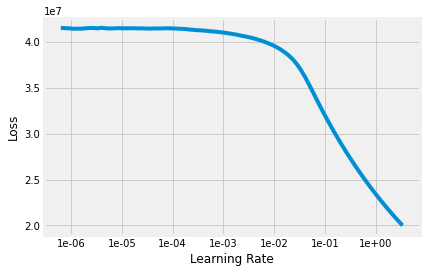

In [ ]:
NN_learner.lr_find()            #finding learning rate
NN_learner.recorder.plot()      #plotting the lerarning rate

In [ ]:
NN_learner.fit_one_cycle(5,1e-2)   #choice of learning rate 1e-2, and training with epochs = 5

epoch,train_loss,valid_loss,time
0,9856.662109,6068.182617,00:34
1,3910.541748,6652.978027,00:34
2,3578.851074,224867.765625,00:34
3,8001.093750,5448.775391,00:34
4,2936.418457,7214.937988,00:34


epoch,train_loss,valid_loss,time


In [ ]:
              #unfreezing the modle to train all the layers...
NN_learner.unfreeze()
NN_learner.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,time
0,8677.967773,39896.203125,00:35
1,2413.222168,26544.367188,00:35


In [ ]:
        #saving the model..
NN_learner.save('RecSys_fastai_1')

In [ ]:
NN_learner.load('RecSys_fastai_1')

##EmbeddingDOTBias Model

In [ ]:
DB_learner = collab_learner(data, 
                            n_factors=40,
                            y_range = (min_qty,max_qty),
                            wd = 1e-1 )

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


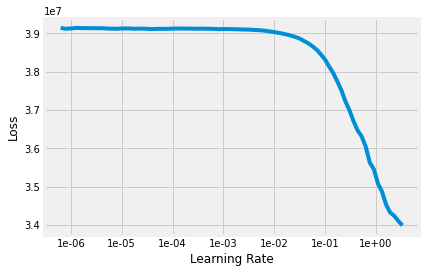

In [ ]:
DB_learner.lr_find()
DB_learner.recorder.plot()

In [ ]:
DB_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,time
0,147485.671875,164096.484375,00:23
1,233322.562500,226176.781250,00:24
2,191734.359375,194010.968750,00:23
3,185316.171875,147920.937500,00:23
4,114342.406250,142950.937500,00:23


In [ ]:
              #unfreezing the modle to train all the layers...
DB_learner.unfreeze()
DB_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,time
0,143690.468750,175854.703125,00:23
1,228035.062500,223620.640625,00:22
2,144558.000000,183603.640625,00:23
3,128310.718750,147213.234375,00:23
4,85034.078125,143107.000000,00:23


In [ ]:
DB_learner.save('DotBiasModel')

In [ ]:
DB_learner.load('DotBiasModel')

##Model Interpretation


-  The embedding are low dimensional representation for users and items, 

- The embeddings learned represents the style and kind of items and users

-  these representation contains interesting features which we can extract and visualize

- the item biases and weights can be extracted;

- this will give insights of what items should be ranked lower or higher using the embedding bias.

-  and the embedding weights tells how similar some of the most popular books are

In [ ]:
                                    ##get most popular items based on mean  quantities...
                                    #mean rating.....
user_item_desr.groupby(['Description'])['Quantity'].mean().sort_values(ascending=False).head(20)

Description
TEA TIME TEA TOWELS                    2600.000000
GIRLS ALPHABET IRON ON PATCHES          693.333333
ASSTD DESIGN 3D PAPER STICKERS          472.482759
POTTING SHED CANDLE CITRONELLA          402.000000
SMALL CHINESE STYLE SCISSOR             392.000000
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     390.400000
SET/5 RED SPOTTY LID GLASS BOWLS        288.000000
ASSORTED INCENSE PACK                   252.000000
MISELTOE HEART WREATH CREAM             240.000000
MINI HIGHLIGHTER PENS                   210.000000
ASSORTED LAQUERED INCENSE HOLDERS       209.666667
LUNCH BAG RED SPOTTY                    200.000000
BOYS ALPHABET IRON ON PATCHES           192.200000
EMPIRE DESIGN ROSETTE                   184.173913
WORLD WAR 2 GLIDERS ASSTD DESIGNS       173.345277
BROCADE RING PURSE                      168.823529
POPART WOODEN PENCILS ASST              145.901639
ASSORTED FLOWER COLOUR "LEIS"           143.013889
BLACK WINE GLASS                        139.083333
RAIN PONCHO        

In [ ]:
                                  ##getting most popular items by item quantities...
top_counts= user_item_desr.groupby('Description')['Quantity'].count()    
top_items = top_counts.sort_values(ascending=False).index.values[:1000]
top_items[:10]

array(['REGENCY CAKESTAND 3 TIER', 'WHITE HANGING HEART T-LIGHT HOLDER',
       'PARTY BUNTING', 'ASSORTED COLOUR BIRD ORNAMENT',
       'SET OF 3 CAKE TINS PANTRY DESIGN ', 'JUMBO BAG RED RETROSPOT',
       'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS ",
       'NATURAL SLATE HEART CHALKBOARD ', 'BAKING SET 9 PIECE RETROSPOT '],
      dtype=object)

In [ ]:
          ##getting item_name incase we have item_id
# items_name = []
# for item in top_items:
#     items_name.append(user_item_desr[(user_item_desr['id']==int(item))]['title'].iloc[0])
# items_name = np.array(items_name)

- Extracting  the biases as well as the mean ratings gives us informations about movies that are generally rated low or high no matter what user is rating them.

 - In most cases, high mean ratings correspond to high biases and viceversa.

 - However, there are some items with high mean rating for whom the model has provided a low bias

In [ ]:
                    ##getting biases for top items..
item_bias = DB_learner.weight(top_items,is_item=True)
item_bias

tensor([[-0.5824,  0.5824,  0.5824,  ...,  0.5824,  0.5824,  0.5824],
        [-0.5161,  0.5161,  0.5161,  ...,  0.5161,  0.5161,  0.5161],
        [-0.5245,  0.5245,  0.5245,  ...,  0.5245,  0.5245,  0.5245],
        ...,
        [-0.3529,  0.3529,  0.3529,  ...,  0.3529,  0.3529,  0.3529],
        [-0.3985,  0.3985,  0.3985,  ...,  0.3985,  0.3985,  0.3985],
        [-0.4299,  0.4299,  0.4299,  ...,  0.4299,  0.4299,  0.4299]])

In [ ]:
item_bias.shape   #40 latent items for 1000items...

torch.Size([1000, 40])

In [ ]:
mean_item_qqt = user_item_desr.groupby(['Description'])['Quantity'].mean()
get_ratings = [(b,top_items[i],mean_item_qqt.loc[tb]) 
               for i, (tb,b) in enumerate(zip(top_items,item_bias)) 
               ]

In [ ]:
get_ratings[:10]

[(tensor([ 0.5618, -0.5618, -0.5618,  0.5618,  0.5618, -0.5618, -0.5618,  0.5618,
          -0.5618, -0.5618, -0.5618,  0.5618, -0.5618, -0.5618, -0.5618, -0.5618,
          -0.5618, -0.5618,  0.5618, -0.5618,  0.5618,  0.5618, -0.5618, -0.5618,
           0.5618, -0.5618, -0.5618,  0.5618,  0.5618, -0.5618, -0.5618, -0.5618,
          -0.5618,  0.5618,  0.5618, -0.5618, -0.5618,  0.5618,  0.5618,  0.5618]),
  'REGENCY CAKESTAND 3 TIER',
  13.163636363636364),
 (tensor([ 0.5016, -0.5016, -0.5017,  0.5016,  0.5017, -0.5017, -0.5017,  0.5017,
          -0.5017, -0.5016, -0.5017,  0.5016, -0.5016, -0.5016, -0.5017, -0.5016,
          -0.5016, -0.5016,  0.5017, -0.5016,  0.5016,  0.5016, -0.5017, -0.5016,
           0.5016, -0.5016, -0.5016,  0.5017,  0.5017, -0.5016, -0.5016, -0.5017,
          -0.5017,  0.5016,  0.5017, -0.5017, -0.5016,  0.5017,  0.5016,  0.5017]),
  'WHITE HANGING HEART T-LIGHT HOLDER',
  39.896028037383175),
 (tensor([ 0.5172, -0.5172, -0.5172,  0.5172,  0.5172, -0.51

In [ ]:
# item0 = lambda o:o[0]
# print(sorted(get_ratings, key=item0)[:15])

In [ ]:
#print(sorted(get_ratings, key=item0, reverse=True)[:15])

In [ ]:
                    ##getting biases for top items..
item_weight = DB_learner.weight(top_items,is_item=True)
item_weight

tensor([[-0.5824,  0.5824,  0.5824,  ...,  0.5824,  0.5824,  0.5824],
        [-0.5161,  0.5161,  0.5161,  ...,  0.5161,  0.5161,  0.5161],
        [-0.5245,  0.5245,  0.5245,  ...,  0.5245,  0.5245,  0.5245],
        ...,
        [-0.3529,  0.3529,  0.3529,  ...,  0.3529,  0.3529,  0.3529],
        [-0.3985,  0.3985,  0.3985,  ...,  0.3985,  0.3985,  0.3985],
        [-0.4299,  0.4299,  0.4299,  ...,  0.4299,  0.4299,  0.4299]])

In [ ]:
item_pCA = item_weight.pca(3)    #converting to 
item_pCA

tensor([[ 1.1546e+00, -1.2422e-07, -1.6538e-07],
        [ 7.3472e-01, -6.1202e-08, -1.5739e-07],
        [ 7.8837e-01, -7.8939e-08, -1.2637e-07],
        ...,
        [-2.9719e-01, -4.9788e-08,  9.2133e-08],
        [-8.7520e-03, -1.9246e-08,  1.2344e-08],
        [ 1.8974e-01, -1.3979e-08, -3.5623e-08]])

In [ ]:
fac0,fac1,fac2 = item_pCA.t()   #getting 1st 3 principal components...

In [ ]:
item_comp_1 = [(f, i) for f,i in zip(fac0, top_items)]   #getting information from the 1st component
#item_comp

In [ ]:
get_1st_components = sorted(item_comp_1, key=itemgetter(0), reverse=True)[:10]   ##sorted in ascending order
get_1st_components                                                               ##item with HIGHTEST Bias

[(tensor(1.1546), 'REGENCY CAKESTAND 3 TIER'),
 (tensor(0.7884), 'PARTY BUNTING'),
 (tensor(0.7857), 'POSTAGE'),
 (tensor(0.7347), 'WHITE HANGING HEART T-LIGHT HOLDER'),
 (tensor(0.6995), 'NATURAL SLATE HEART CHALKBOARD '),
 (tensor(0.6652), 'DOORMAT WELCOME TO OUR HOME'),
 (tensor(0.6450), 'ROUND CAKE TIN VINTAGE GREEN'),
 (tensor(0.5360), 'CHILDS BREAKFAST SET DOLLY GIRL '),
 (tensor(0.5342), 'MINT DINER WALL CLOCK'),
 (tensor(0.5290), 'HEART OF WICKER SMALL')]

In [ ]:
sorted(item_comp_1, key=itemgetter(0))[:10]   #first components without sorting    
                                              #....Items with LOWEST bias 

[(tensor(-0.6997), 'DISCO BALL CHRISTMAS DECORATION'),
 (tensor(-0.6743), 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'),
 (tensor(-0.6464), 'BUBBLEGUM RING ASSORTED'),
 (tensor(-0.6073), 'POPCORN HOLDER'),
 (tensor(-0.5987), 'PLACE SETTING WHITE HEART'),
 (tensor(-0.5976), 'FUNKY DIVA PEN'),
 (tensor(-0.5911), 'BROCADE RING PURSE '),
 (tensor(-0.5837), 'PENS ASSORTED FUNNY FACE'),
 (tensor(-0.5440), 'STAR DECORATION PAINTED ZINC '),
 (tensor(-0.5422), 'CHRISTMAS PUDDING TRINKET POT ')]

In [ ]:
item_comp_2 = [(f, i) for f,i in zip(fac1, top_items)]                           ##getting information from the 1st component
get_2nd_components = sorted(item_comp_2, key=itemgetter(0), reverse=True)[:10]   ##highest bias elements...
get_2nd_components

[(tensor(1.5146e-07), 'JUMBO BAG STRAWBERRY'),
 (tensor(1.4371e-07), 'DISCO BALL CHRISTMAS DECORATION'),
 (tensor(1.3611e-07), 'WRAP VINTAGE LEAF DESIGN'),
 (tensor(1.1068e-07), 'VICTORIAN GLASS HANGING T-LIGHT'),
 (tensor(1.0094e-07), 'ROLL WRAP VINTAGE SPOT '),
 (tensor(9.7865e-08), 'FAWN BLUE HOT WATER BOTTLE'),
 (tensor(9.7061e-08), 'WELCOME  WOODEN BLOCK LETTERS'),
 (tensor(9.4468e-08), 'SET OF 60 VINTAGE LEAF CAKE CASES '),
 (tensor(9.1317e-08), 'TOY TIDY PINK POLKADOT'),
 (tensor(8.8414e-08), 'PACK 3 BOXES CHRISTMAS PANNETONE')]

In [ ]:
sorted(item_comp_2, key=itemgetter(0))[:10]   #first components without sorting
                                              #lowest bias elements.....

[(tensor(-1.4053e-07), 'TREASURE ISLAND BOOK BOX'),
 (tensor(-1.3788e-07), 'RED RETROSPOT PICNIC BAG'),
 (tensor(-1.2809e-07), 'FELTCRAFT 6 FLOWER FRIENDS'),
 (tensor(-1.2722e-07), 'FELTCRAFT CUSHION OWL'),
 (tensor(-1.2422e-07), 'REGENCY CAKESTAND 3 TIER'),
 (tensor(-1.2148e-07), 'MAKE YOUR OWN FLOWERPOWER CARD KIT'),
 (tensor(-1.0073e-07), 'ALARM CLOCK BAKELIKE ORANGE'),
 (tensor(-9.7747e-08), 'RED RETROSPOT ROUND CAKE TINS'),
 (tensor(-9.5458e-08), 'HEART OF WICKER LARGE'),
 (tensor(-9.4814e-08), 'SINGLE ANTIQUE ROSE HOOK IVORY')]

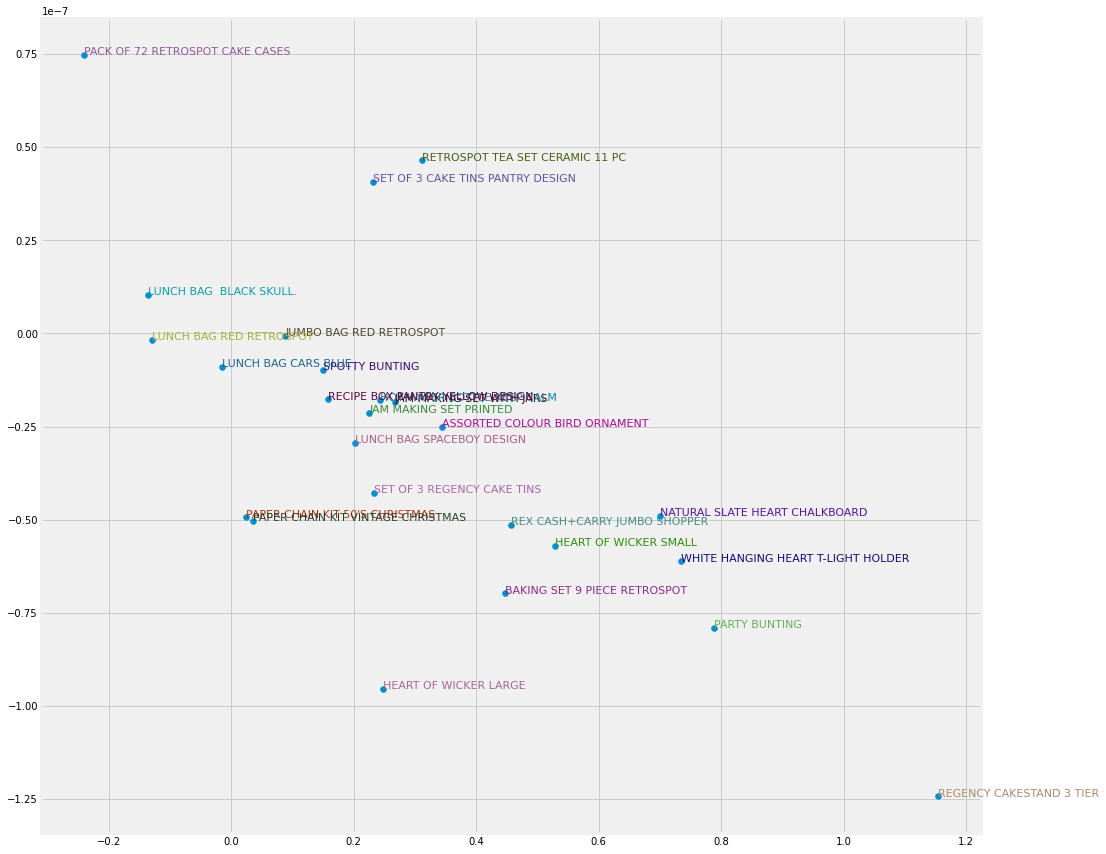

In [ ]:
                      #visualize the two principal components using a matplotlip
idx = np.random.choice(len(top_items), 25, replace=False)   #25 points
idx = list(range(25))
X = fac0[idx]
Y = fac1[idx]

plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_items[idx], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

##References:

- [collaborative-filtering-with-fastai](https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

- [deep-learning-for-collaborative-filtering-using-fastai](https://medium.com/quantyca/deep-learning-for-collaborative-filtering-using-fastai-b28e197ccd59)

#Part 5B

- This method uses Neural network with embeddings to understand how users would feel towards certain items

- From where we can recommend items for them to use

In [ ]:
n_users = user_item_desr.CustomerID.nunique()    #get number of unique customers..
n_items = user_item_desr.Description.nunique()   #get number of unique items..  

##Neural Network with Embeddings

- Creating a **nn.EmbeddingDot** class : 

  - this class does a dot product of two embedding matrices

- Step_1: Creating random weights btw (0 and 0.05):
   
- Step_2 : Adding Embedding matrices  and latent factors:

    - Creating Emd matrix for both user ids and item ids

    - An embedding is basically an array lookup

    - Latent factors helps to reduce the need for feature engineering


In [ ]:
class EmbeddingDot(nn.Module):              #nn.module to create NeuralNet in pytorch 
  def __init__(self,n_users,n_items):       #this class does a dot product of embedding matrices
    super().__init__()                      #this will allows us to call the base class explicitly

    ##adding embedding matrices and latent factors
    self.users_emb = nn.Embedding(n_users,n_factors) 
    self.items_emb = nn.Embedding(n_items,n_factors)
     
    ####creating random weights...####
    self.users_emb.weight.data.uniform_(0,0.05)     #weight is uniformly distributed btw 0 and 0.05
    self.items_emb.weight.data.unifrom_(0,0.05)     #the _ operator at the end of the "uniform_" denotes an inplace operation
                                                    #inplace operation: this does not make any copy

    ###adding forward function to our class...
    def forward(self,cats,conts):                   #cats == catergorical variable || conts == continuous variables
      users = cats[:,0]                             #cats[:,0]--> a minibatch of users 
      items = cats[:,1]                             #cats[:,1]--> a minibatch of items

      users_emb = self.users_emb(users)      #for each minibatch, we do an array checkup for the emb_matrix
      items_emb = self.items_emb(items)      #...whc returns a single row in the weight matrix  

      user_item_cross_product = (users_emb*items_emb).sum(1).view(-1,1)
      return user_item_cross_product

##Training the model

- Batch size = 64

- features : *users* and *items*

- target: *Quantities*

- Optimizer: *Stocastic Gradient Descent*
    
    - SGD is computationally less intensive then GD bcos there is some randomeness when selecting datapoint to calculate derivative 

In [ ]:
        ##training from fastai 
from fastai.collab import *
from fastai.tabular import *

In [ ]:
user_name = 'CustomerID'
item_name = 'Description'
qqt_name = 'Quantity' 

X = user_item_desr.drop(['Quantity'],axis = 1)            #features..
y = user_item_desr['Quantity'].astype(np.float32)         #quantities == ratings

                    ##geting proper data for modelling
data = ColumnarModelData.from_data_frame(path,
                                         val_idxs,
                                         X,y,
                                         [user_name,item_name],
                                         bs = 64)
                      ##creating an embeddingdot model    
emb_model = EmbeddingDot(n_users,n_items).cuda()
                     #using stocastic gradient descent...
opt = optim.SGD(emb_model.parameters(),1e-1,
                weight_decay = 1e-5,
                momentum = 0.9)

In [ ]:
          #fitting of model with 3 epochs...and mean sqr error
fit(model,data,3,opt,F.mse_loss)

##Adding Bias and Dropout

- Fastai creates a neaural network for collaborative filtering using **collab_learner**

- there is a need to introduce *Bias* and *dropout* to through the *collab_learner*

- There is a need to add add bias to our model;
  - User Bias accounts for people who give high ratint for every movies(bought large quanties of every items)

  - Item bias would account for people who tend to buy high quantities of certain items

In [ ]:
cols = [user_name,item_name,qqt_name]
data = (CollabDataBunch.from_df(
                    user_item_desr[cols],
                    user_name = user_name,
                    item_name = item_name,
                    rating_name = qqt_name,
                    seed = 42,
                    valid_pct = 0.2,
                    bs = 2**11))


y_range = (qty_min, qty_max)

emb_learn = collab_learner(
              data,
              n_factors = 50,
              y_range = y_range
) 

In [ ]:
emb_learn.lr_find()
emb_learn.recorder.plot(suggestion=True)

In [ ]:
emb_learn.fit_one_cycle(5,4.79E-2,wd=1e-1)

###Reference for NN:

- [RecSys with Pytorch](https://spiyer99.github.io/Recommendation-System-in-Pytorch/)

- [RecSys with NVTabular](https://medium.com/rapids-ai/gpu-recommender-systems-with-nvtabular-eee056c37ea0#cid=av01_so-twit_en-us)

## Part 6: RecSys with PyTorch - References

[RecSys with PyTorch-GitHub](https://github.com/devforfu/pytorch_playground/blob/master/movielens.ipynb)


[RecSys with PyTorch](https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9)

# Evaluation of Recommeder System:

- [Microsoft Evaluation Metrics](https://github.com/microsoft/recommenders/tree/master/examples/03_evaluate) 

- [Evaluating Recommender Systems](https://medium.com/fnplus/evaluating-recommender-systems-with-python-code-ae0c370c90be)
